In [2]:
import warnings
import pandas as pd
from sodapy import Socrata
import pickle
import pandas as pd

warnings.filterwarnings("ignore", category=UserWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import folium
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', None)

In [3]:
# client = Socrata("data.cityofnewyork.us", None)

# client.timeout = 1000
# results = client.get("erm2-nwe9", limit=1500000)

# df = pd.DataFrame.from_records(results)
# df.to_pickle('data.pkl')


# Load
df = pd.read_pickle('data.pkl')

##  Project Understanding & Business Context:
- Predicting response times for NYC service requests is crucial for resource allocation and citizen satisfaction
- Response time prediction can help set realistic expectations for citizens
- Different complaint types may have varying priority levels and handling procedures
- Seasonal and geographical patterns might significantly influence response times

Steps that I will tackle: `Raw Data → Cleaning → Feature Engineering → Model Training → Evaluation → Recommendation`

In [4]:
print("Dataset Shape:", df.shape)

Dataset Shape: (1500000, 47)


In [5]:
df[0:2]

,unique_key,created_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,address_type,city,facility_type,status,due_date,resolution_description,resolution_action_updated_date,community_board,bbl,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_facility_name,park_borough,latitude,longitude,location,:@computed_region_efsh_h5xi,:@computed_region_f5dn_yrer,:@computed_region_yeji_bk3q,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih,:@computed_region_7mpf_4k6g,closed_date,cross_street_1,cross_street_2,intersection_street_1,intersection_street_2,landmark,bridge_highway_name,bridge_highway_segment,vehicle_type,bridge_highway_direction,taxi_pick_up_location,taxi_company_borough,road_ramp
0,63217914,2024-11-27T02:18:33.000,DSNY,Department of Sanitation,Graffiti,Graffiti,Mixed Use,10002,104 CANAL STREET,CANAL STREET,ADDRESS,NEW YORK,N/A,Open,2024-12-27T02:18:33.000,The graffiti on this property has been schedul...,2024-11-27T02:18:33.000,03 MANHATTAN,1002920012,MANHATTAN,985915,199963,UNKNOWN,Unspecified,MANHATTAN,40.71552882476193,-73.99399385839209,"{'latitude': '40.71552882476193', 'longitude':...",11723,70,4,32,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,63213539,2024-11-27T02:16:36.000,DSNY,Department of Sanitation,Graffiti,Graffiti,Comercial,10002,103 CANAL STREET,CANAL STREET,ADDRESS,NEW YORK,N/A,Open,2024-12-27T02:16:36.000,The graffiti on this property has been schedul...,2024-11-27T02:16:36.000,03 MANHATTAN,1003010001,MANHATTAN,985896,199977,UNKNOWN,Unspecified,MANHATTAN,40.71556725496769,-73.99406239352157,"{'latitude': '40.71556725496769', 'longitude':...",11723,70,4,32,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.created_date.value_counts()

created_date
2024-11-14T13:57:00.000    38
2024-11-14T14:00:00.000    36
2024-11-04T15:00:00.000    35
2024-11-04T14:51:00.000    33
2024-11-14T13:33:00.000    33
                           ..
2024-06-26T20:51:31.000     1
2024-06-26T20:51:30.000     1
2024-06-26T20:54:49.000     1
2024-06-26T20:54:44.000     1
2024-11-27T01:53:20.000     1
Name: count, Length: 1229613, dtype: int64

In [7]:
min_date = df['created_date'].min()
max_date = df['created_date'].max()
print(f"Data Range: {min_date} to {max_date}")

Data Range: 2024-06-26T20:51:10.000 to 2024-11-27T02:18:33.000


In [8]:
print("\nData Types:\n", df.dtypes)


Data Types:
 unique_key                        object
created_date                      object
agency                            object
agency_name                       object
complaint_type                    object
descriptor                        object
location_type                     object
incident_zip                      object
incident_address                  object
street_name                       object
address_type                      object
city                              object
facility_type                     object
status                            object
due_date                          object
resolution_description            object
resolution_action_updated_date    object
community_board                   object
bbl                               object
borough                           object
x_coordinate_state_plane          object
y_coordinate_state_plane          object
open_data_channel_type            object
park_facility_name                object
pa

In [9]:
# Calculate the percentage of missing values
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Display the result
print("\nMissing Values (%):\n", missing_percentage)


Missing Values (%):
 unique_key                         0.000000
created_date                       0.000000
agency                             0.000000
agency_name                        0.000000
complaint_type                     0.000000
descriptor                         1.433733
location_type                     12.070800
incident_zip                       0.954933
incident_address                   3.234467
street_name                        3.238467
address_type                       0.378400
city                               5.058400
facility_type                     92.111800
status                             0.000000
due_date                          99.477733
resolution_description             4.713800
resolution_action_updated_date     3.795467
community_board                    0.000000
bbl                               11.159000
borough                            0.000000
x_coordinate_state_plane           1.376400
y_coordinate_state_plane           1.374133
open_data_

In [10]:
# Explore Incident Zip
df['incident_zip'].unique()

array(['10002', '10453', '11365', '11236', '10011', '11207', '11235',
       '11423', '11373', '11237', '11229', '10458', '10036', '10461',
       '10452', '11204', '11214', '10026', '11377', nan, '10305', '11368',
       '10451', '11206', '10013', '11421', '10471', '11212', '10031',
       '11205', '11224', '10014', '10462', '10028', '10040', '11691',
       '10467', '11219', '10457', '10009', '10456', '11101', '10034',
       '11211', '11360', '11104', '11369', '11233', '10003', '11419',
       '10016', '11201', '11218', '11230', '10032', '10037', '10314',
       '11432', '10006', '11216', '11378', '11225', '11374', '11103',
       '10460', '10304', '10454', '10030', '10039', '11102', '11372',
       '11209', '11694', '11208', '11226', '11364', '11361', '10465',
       '10472', '10025', '10466', '10029', '11357', '11234', '10019',
       '11422', '11379', '11370', '11692', '10035', '11435', '10474',
       '11238', '10012', '10463', '11221', '11215', '10470', '10075',
       '11415',

In [11]:
# Clean ZIP codes and remove invalid/null values
df["incident_zip"] = df["incident_zip"].apply(
    lambda x: str(int(float(x.split("-")[0])))
    if isinstance(x, str) and "-" in x
    else str(int(float(x)))
    if pd.notnull(x)
    else np.nan
)

In [12]:
# Check the number of rows before dropping
rows_before = df.shape[0]

# Drop rows with NaN in the 'incident_zip' column
df = df.dropna(subset=['incident_zip'])

# Check the number of rows after dropping
rows_after = df.shape[0]

# Print the number of rows dropped
print(f"Number of rows dropped: {rows_before - rows_after} for empty incident_zip column")

Number of rows dropped: 14324 for empty incident_zip column


In [13]:
# Check the number of rows before dropping
rows_before = df.shape[0]

# Drop rows with missing values in specific columns
df = df.dropna(subset=['latitude', 'longitude', 'closed_date'])

# Check the number of rows after dropping
rows_after = df.shape[0]

# Print the number of rows dropped
print(f"Number of rows dropped: {rows_before - rows_after}" + " for empty latitude, longitude, and closed_date columns")

Number of rows dropped: 127202 for empty latitude, longitude, and closed_date columns


In [14]:
df['agency'].unique()

array(['DSNY', 'NYPD', 'DEP', 'DOT', 'HPD', 'DOB', 'DPR', 'DHS', 'TLC',
       'DOHMH', 'DCWP', 'DOE', 'OTI', 'EDC'], dtype=object)

In [15]:
df['complaint_type'].unique()

array(['Graffiti', 'Blocked Driveway', 'Illegal Parking',
       'Noise - Residential', 'Traffic', 'Noise - Vehicle',
       'Noise - Commercial', 'Non-Emergency Police Matter',
       'Noise - Street/Sidewalk', 'Encampment', 'Abandoned Vehicle',
       'Drug Activity', 'Drinking', 'Water System', 'Noise - Park',
       'Animal-Abuse', 'Traffic Signal Condition', 'Illegal Fireworks',
       'Commercial Disposal Complaint', 'Vendor Enforcement',
       'Panhandling', 'HEAT/HOT WATER', 'Dirty Condition',
       'Derelict Vehicles', 'General Construction/Plumbing', 'Elevator',
       'Building/Use', 'Violation of Park Rules',
       'Emergency Response Team (ERT)',
       'Special Projects Inspection Team (SPIT)', 'Urinating in Public',
       'Homeless Person Assistance', 'BEST/Site Safety',
       'Real Time Enforcement', 'Lost Property', 'Electrical', 'Plumbing',
       'Indoor Air Quality', 'Investigations and Discipline (IAD)',
       'Asbestos', 'Street Sweeping Complaint', 'Obstruc

In [16]:
df['city'].unique()

array(['NEW YORK', 'BROOKLYN', 'FAR ROCKAWAY', nan, 'REGO PARK',
       'ASTORIA', 'OAKLAND GARDENS', 'WOODHAVEN', 'JACKSON HEIGHTS',
       'HOLLIS', 'WHITESTONE', 'STATEN ISLAND', 'ARVERNE', 'BRONX',
       'EAST ELMHURST', 'KEW GARDENS', 'RIDGEWOOD', 'CORONA',
       'FOREST HILLS', 'BAYSIDE', 'JAMAICA', 'MASPETH',
       'LONG ISLAND CITY', 'COLLEGE POINT', 'LITTLE NECK',
       'QUEENS VILLAGE', 'SAINT ALBANS', 'WOODSIDE', 'RICHMOND HILL',
       'OZONE PARK', 'SOUTH RICHMOND HILL', 'SUNNYSIDE',
       'SOUTH OZONE PARK', 'ROSEDALE', 'MANHATTAN', 'FLUSHING',
       'GLEN OAKS', 'FRESH MEADOWS', 'SPRINGFIELD GARDENS', 'ELMHURST',
       'MIDDLE VILLAGE', 'HOWARD BEACH', 'FLORAL PARK', 'BELLEROSE',
       'CAMBRIA HEIGHTS', 'QUEENS', 'NEW HYDE PARK', 'BREEZY POINT',
       'LAGUARDIA AIRPORT', 'Franklin Square', 'bronx', 'PELHAM',
       'New York', 'Brooklyn', 'Memphis', 'Long Island City'],
      dtype=object)

In [17]:
df['location_type'].unique()

array(['Mixed Use', nan, 'Street/Sidewalk', 'Residential Building/House',
       'Club/Bar/Restaurant', 'Park/Playground', 'Store/Commercial',
       'Hallway', 'Sidewalk', 'Food Establishment or Vendor', 'Street',
       'RESIDENTIAL BUILDING', 'Common Area', 'Park', 'Residential',
       'Other', 'Taxi', '3+ Family Apt. Building', 'Alley', 'Yard',
       '3+ Family Apartment Building', '1-2 Family Dwelling',
       'House and Store', 'Commercial Building', 'Other (Explain Below)',
       'Gutter', 'House of Worship', '3+ Family Mixed Use Building',
       'Hospital', 'Business', 'Lot', 'Lobby', 'Intersection',
       'Street/Curbside', '1-2 Family Mixed Use Building',
       'Traffic Island or Median', 'Restaurant/Bar/Deli/Bakery',
       'Residence', 'Residential Building', 'Stairwell', 'Vacant Lot',
       'Commercial', 'Catch Basin/Sewer', 'Building Entrance',
       'Parking Lot/Garage', 'Private Property', 'Construction Site',
       'Comercial', 'Bus Stop Shelter', 'School', '1

In [18]:
df['status'].unique()

array(['Closed', 'Open', 'Assigned', 'Pending', 'Unspecified', 'Started'],
      dtype=object)

In [19]:
df['borough'].unique()

array(['MANHATTAN', 'BROOKLYN', 'QUEENS', 'STATEN ISLAND', 'BRONX',
       'Unspecified'], dtype=object)

### Data Quality Issues:
- **"city" / "complaint_type"/ "location_type" columns**: Inconsistent capitalization
  - Some cities in uppercase
  - Others in lowercase

  
- **"borough" column**: Data completeness
  - Contains 'Unspecified' values

In [20]:
# Filter for unspecified boroughs and select relevant columns
unspecified_boroughs = df[df['borough'] == 'Unspecified'][['agency', 'city']].copy()

# Display unique combinations and their counts
unspecified_summary = unspecified_boroughs.value_counts().reset_index()
unspecified_summary.columns = ['agency', 'city', 'count']

# Display the results
print("Summary of records with Unspecified boroughs:")
display(unspecified_summary)

Summary of records with Unspecified boroughs:


,agency,city,count
0,DOT,QUEENS,17
1,NYPD,NEW YORK,8
2,DEP,QUEENS,3
3,DEP,NEW YORK,3
4,DOT,NEW YORK,2
5,DCWP,Memphis,1
6,DCWP,Franklin Square,1
7,DOT,BROOKLYN,1


#### Majority of the data belongs to DOT Agency and occurs in QUEENS

In [21]:
# Calculate percentage of unspecified cases for DOT
nypd_stats = {
    'Total DOT Cases': len(df[df['agency'] == 'DOT']),
    'Unspecified Cases': len(df[(df['agency'] == 'DOT') & (df['borough'] == 'Unspecified')]),
}

nypd_stats['Percentage Unspecified'] = (nypd_stats['Unspecified Cases'] / nypd_stats['Total DOT Cases'] * 100)

print("\nDOT Statistics:")
for key, value in nypd_stats.items():
    if 'Percentage' in key:
        print(f"{key}: {value:.2f}%")
    else:
        print(f"{key}: {value:,}")


DOT Statistics:
Total DOT Cases: 66,467
Unspecified Cases: 23
Percentage Unspecified: 0.03%


#### Boroughs that are not specified are negligible and can be excluded

In [22]:
df = df[df['borough'] != 'Unspecified']

In [23]:
# Number of Status columns with nan
status_nan = len(df[df['status'].isnull()].index)
print(status_nan)

0


In [24]:
def standardize_column(df, column):
    # Create a copy to avoid SettingWithCopyWarning
    df = df.copy()

    # Handle NaN values first
    mask = df[column].notna()

    # Vectorized operation for string standardization
    df.loc[mask, column] = (
        df.loc[mask, column]
        .str.strip()  # Remove leading/trailing spaces
        .str.title()  # Convert to Title Case
        .str.replace("\s+", " ")  # Replace multiple spaces with single space
    )

    return df

# Standardize city names
df = standardize_column(df, "city")
df = standardize_column(df, "complaint_type")
df = standardize_column(df, "location_type")

In [25]:
df['city'].unique()

array(['New York', 'Brooklyn', 'Far Rockaway', nan, 'Rego Park',
       'Astoria', 'Oakland Gardens', 'Woodhaven', 'Jackson Heights',
       'Hollis', 'Whitestone', 'Staten Island', 'Arverne', 'Bronx',
       'East Elmhurst', 'Kew Gardens', 'Ridgewood', 'Corona',
       'Forest Hills', 'Bayside', 'Jamaica', 'Maspeth',
       'Long Island City', 'College Point', 'Little Neck',
       'Queens Village', 'Saint Albans', 'Woodside', 'Richmond Hill',
       'Ozone Park', 'South Richmond Hill', 'Sunnyside',
       'South Ozone Park', 'Rosedale', 'Manhattan', 'Flushing',
       'Glen Oaks', 'Fresh Meadows', 'Springfield Gardens', 'Elmhurst',
       'Middle Village', 'Howard Beach', 'Floral Park', 'Bellerose',
       'Cambria Heights', 'Queens', 'New Hyde Park', 'Breezy Point',
       'Laguardia Airport', 'Pelham'], dtype=object)

In [26]:
df['complaint_type'].unique()

array(['Graffiti', 'Blocked Driveway', 'Illegal Parking',
       'Noise - Residential', 'Traffic', 'Noise - Vehicle',
       'Noise - Commercial', 'Non-Emergency Police Matter',
       'Noise - Street/Sidewalk', 'Encampment', 'Abandoned Vehicle',
       'Drug Activity', 'Drinking', 'Water System', 'Noise - Park',
       'Animal-Abuse', 'Traffic Signal Condition', 'Illegal Fireworks',
       'Commercial Disposal Complaint', 'Vendor Enforcement',
       'Panhandling', 'Heat/Hot Water', 'Dirty Condition',
       'Derelict Vehicles', 'General Construction/Plumbing', 'Elevator',
       'Building/Use', 'Violation Of Park Rules',
       'Emergency Response Team (Ert)',
       'Special Projects Inspection Team (Spit)', 'Urinating In Public',
       'Homeless Person Assistance', 'Best/Site Safety',
       'Real Time Enforcement', 'Lost Property', 'Electrical', 'Plumbing',
       'Indoor Air Quality', 'Investigations And Discipline (Iad)',
       'Asbestos', 'Street Sweeping Complaint', 'Obstruc

In [27]:
df['location_type'].unique()

array(['Mixed Use', nan, 'Street/Sidewalk', 'Residential Building/House',
       'Club/Bar/Restaurant', 'Park/Playground', 'Store/Commercial',
       'Hallway', 'Sidewalk', 'Food Establishment Or Vendor', 'Street',
       'Residential Building', 'Common Area', 'Park', 'Residential',
       'Other', 'Taxi', '3+ Family Apt. Building', 'Alley', 'Yard',
       '3+ Family Apartment Building', '1-2 Family Dwelling',
       'House And Store', 'Commercial Building', 'Other (Explain Below)',
       'Gutter', 'House Of Worship', '3+ Family Mixed Use Building',
       'Hospital', 'Business', 'Lot', 'Lobby', 'Intersection',
       'Street/Curbside', '1-2 Family Mixed Use Building',
       'Traffic Island Or Median', 'Restaurant/Bar/Deli/Bakery',
       'Residence', 'Stairwell', 'Vacant Lot', 'Commercial',
       'Catch Basin/Sewer', 'Building Entrance', 'Parking Lot/Garage',
       'Private Property', 'Construction Site', 'Comercial',
       'Bus Stop Shelter', 'School', '1-3 Family Dwelling', 'Cu

In [28]:
location_mapping = {
    # Street-related
    'Street/Sidewalk': 'Street',
    'Street': 'Street',
    'Sidewalk': 'Street',
    'Street/Curbside': 'Street',
    'Street Area': 'Street',
    'Curb': 'Street',
    'Gutter': 'Street',
    'Intersection': 'Street',
    'Traffic Island Or Median': 'Street',
    'Crosswalk': 'Street',
    'Vehicle Lane': 'Street',
    'Bike Lane': 'Street',
    'Highway': 'Street',
    'Bridge': 'Street',
    'Roadway Tunnel': 'Street',
    
    # Residential
    'Residential Building': 'Residential',
    'Residential Building/House': 'Residential',
    'Residential': 'Residential',
    '3+ Family Apt. Building': 'Residential',
    '3+ Family Apartment Building': 'Residential',
    '1-2 Family Dwelling': 'Residential',
    'Residence': 'Residential',
    'Private Residence': 'Residential',
    'Residential Property': 'Residential',
    'Loft Residence': 'Residential',
    
    # Commercial
    'Store/Commercial': 'Commercial',
    'Commercial Building': 'Commercial',
    'Commercial': 'Commercial',
    'Business': 'Commercial',
    'Comercial': 'Commercial',
    'Office Building': 'Commercial',
    'Retail Store': 'Commercial',
    'Store': 'Commercial',
    'Commercial Property': 'Commercial',
    
    # Food & Entertainment
    'Club/Bar/Restaurant': 'Food & Entertainment',
    'Restaurant/Bar/Deli/Bakery': 'Food & Entertainment',
    'Food Establishment Or Vendor': 'Food & Entertainment',
    'Food Cart Vendor': 'Food & Entertainment',
    'Restaurant': 'Food & Entertainment',
    'Catering Service': 'Food & Entertainment',
    
    # Public Spaces
    'Park/Playground': 'Public Space',
    'Park': 'Public Space',
    'Public Garden': 'Public Space',
    'Public Garden/Park': 'Public Space',
    'Public Park/Garden': 'Public Space',
    'Beach': 'Public Space',
    
    # Mixed Use
    'Mixed Use': 'Mixed Use',
    'House And Store': 'Mixed Use',
    '3+ Family Mixed Use Building': 'Mixed Use',
    '1-2 Family Mixed Use Building': 'Mixed Use',
    '1-3 Family Mixed Use Building': 'Mixed Use',
    'Mixed Use Building': 'Mixed Use'
}

# Apply the mapping to the 'location_type' column
df['location_type'] = df['location_type'].map(location_mapping).fillna('Other')

In [29]:
# Calculate missing cities percentage by agency
missing_cities = df[df['city'].isna()].groupby('agency').size()
total_by_agency = df.groupby('agency').size()
missing_percentage = (missing_cities / total_by_agency * 100).round(2)

# Create a summary DataFrame
missing_summary = pd.DataFrame({
    'Total Records': total_by_agency,
    'Missing Cities': missing_cities,
    'Missing Percentage': missing_percentage
}).sort_values('Missing Cities', ascending=False)

print("Summary of Missing Cities by Agency:")
print(missing_summary)

Summary of Missing Cities by Agency:
        Total Records  Missing Cities  Missing Percentage
agency                                                   
NYPD           696156         32441.0                4.66
DSNY           133547          8351.0                6.25
DOT             66444          6752.0               10.16
DPR             38637          2001.0                5.18
TLC              8544          1343.0               15.72
DHS             12144           519.0                4.27
DCWP             7921           390.0                4.92
EDC              6034            71.0                1.18
DOHMH           25283            44.0                0.17
DOE               414             2.0                0.48
DEP             81748             NaN                 NaN
DOB             43763             NaN                 NaN
HPD            237691             NaN                 NaN
OTI                57             NaN                 NaN


In [30]:
# Number of rows before dropping
rows_before = len(df)

# Drop rows with null values in the 'City' column
df = df[df['city'].notna()]

# Number of rows after dropping
rows_after = len(df)

print(f"Number of rows dropped: {rows_before - rows_after} for city")

Number of rows dropped: 51914 for city


In [31]:
# Convert date columns
date_columns = ['created_date', 'closed_date', 'due_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col])
    
# Calculate response time (in hours)
df['response_time'] = (df['closed_date'] - df['created_date']).dt.total_seconds()/3600

In [32]:
df['response_time'].describe()

count    1.306469e+06
mean     9.378464e+01
std      2.565678e+02
min     -1.584017e+03
25%      9.305556e-01
50%      4.966111e+00
75%      5.783333e+01
max      3.648528e+03
Name: response_time, dtype: float64

#### min = -1.584017e+03

In [33]:
# Filter rows with negative response times
df[df['response_time'] < 0].head(3)

,unique_key,created_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,address_type,city,facility_type,status,due_date,resolution_description,resolution_action_updated_date,community_board,bbl,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_facility_name,park_borough,latitude,longitude,location,:@computed_region_efsh_h5xi,:@computed_region_f5dn_yrer,:@computed_region_yeji_bk3q,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih,:@computed_region_7mpf_4k6g,closed_date,cross_street_1,cross_street_2,intersection_street_1,intersection_street_2,landmark,bridge_highway_name,bridge_highway_segment,vehicle_type,bridge_highway_direction,taxi_pick_up_location,taxi_company_borough,road_ramp,response_time
5814,63217009,2024-11-26 11:29:00,DOT,Department of Transportation,Street Light Condition,Street Light Out,Other,11101,NaN,NaN,INTERSECTION,Queens,NaN,Pending,NaT,Service Request status for this request is ava...,2024-11-22T11:28:00.000,01 QUEENS,NaN,QUEENS,1000120,213269,UNKNOWN,Unspecified,QUEENS,40.75203643545253,-73.9427208940423,"{'latitude': '40.75203643545253', 'longitude':...",16858,53,3,33,66,66,2024-11-22 11:28:00,NaN,NaN,22 STREET,QUEENS PLAZA NORTH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-96.016667
5840,63210833,2024-11-26 11:27:00,DOT,Department of Transportation,Street Light Condition,Fixture/Luminaire Door Open,Other,10457,NaN,NaN,INTERSECTION,Bronx,NaN,Pending,NaT,Service Request status for this request is ava...,2024-11-22T11:27:00.000,03 BRONX,NaN,BRONX,1011400,245417,UNKNOWN,Unspecified,BRONX,40.84024646755632,-73.90187839047073,"{'latitude': '40.84024646755632', 'longitude':...",10935,34,5,42,25,25,2024-11-22 11:27:00,NaN,NaN,WASHINGTON AVENUE,EAST 172 STREET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-96.000000
5868,63216713,2024-11-26 11:24:00,DOT,Department of Transportation,Street Light Condition,Lamppost Base Door/Cover Open,Other,11105,EAST RIVER,EAST RIVER,PLACENAME,Astoria,NaN,Pending,NaT,Service Request status for this request is ava...,2024-11-21T11:23:00.000,01 QUEENS,NaN,QUEENS,1009432,228502,UNKNOWN,Unspecified,QUEENS,40.79382539642206,-73.90905431510038,"{'latitude': '40.79382539642206', 'longitude':...",NaN,NaN,NaN,NaN,NaN,NaN,2024-11-21 11:23:00,21 ST,EAST RIVER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-120.016667


In [34]:
# Remove rows where response_time is negative
df = df[df['response_time'] >= 0]

In [35]:
# Create map centered on NYC
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Sample points for visualization
sample_df = df.dropna(subset=['latitude', 'longitude']).sample(1000)

# Add points to map
for idx, row in sample_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color='red',
        fill=True
    ).add_to(nyc_map)

nyc_map

In [36]:
# # Time-based features
# df['created_hour'] = df['created_date'].dt.hour
# df['created_day'] = df['created_date'].dt.day_name()
# df['created_month'] = df['created_date'].dt.month

In [37]:
df[0:2]

,unique_key,created_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,address_type,city,facility_type,status,due_date,resolution_description,resolution_action_updated_date,community_board,bbl,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_facility_name,park_borough,latitude,longitude,location,:@computed_region_efsh_h5xi,:@computed_region_f5dn_yrer,:@computed_region_yeji_bk3q,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih,:@computed_region_7mpf_4k6g,closed_date,cross_street_1,cross_street_2,intersection_street_1,intersection_street_2,landmark,bridge_highway_name,bridge_highway_segment,vehicle_type,bridge_highway_direction,taxi_pick_up_location,taxi_company_borough,road_ramp,response_time
9,63215850,2024-11-27 02:00:14,DSNY,Department of Sanitation,Graffiti,Graffiti,Mixed Use,10002,18 ORCHARD STREET,ORCHARD STREET,ADDRESS,New York,N/A,Closed,NaT,NaN,2024-11-27T02:22:24.000,03 MANHATTAN,1002987502,MANHATTAN,986562,199889,UNKNOWN,Unspecified,MANHATTAN,40.71532556704347,-73.99165996572897,"{'latitude': '40.71532556704347', 'longitude':...",11723,70,4,32,4,4,2024-11-27 02:22:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.369444
30,63211945,2024-11-27 01:43:35,DSNY,Department of Sanitation,Graffiti,Graffiti,Other,10002,60 ORCHARD STREET,ORCHARD STREET,ADDRESS,New York,N/A,Closed,NaT,NaN,2024-11-27T02:22:24.000,03 MANHATTAN,1003097502,MANHATTAN,986785,200457,UNKNOWN,Unspecified,MANHATTAN,40.71688452994089,-73.99085532811608,"{'latitude': '40.71688452994089', 'longitude':...",11723,70,4,32,4,4,2024-11-27 02:22:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.646944


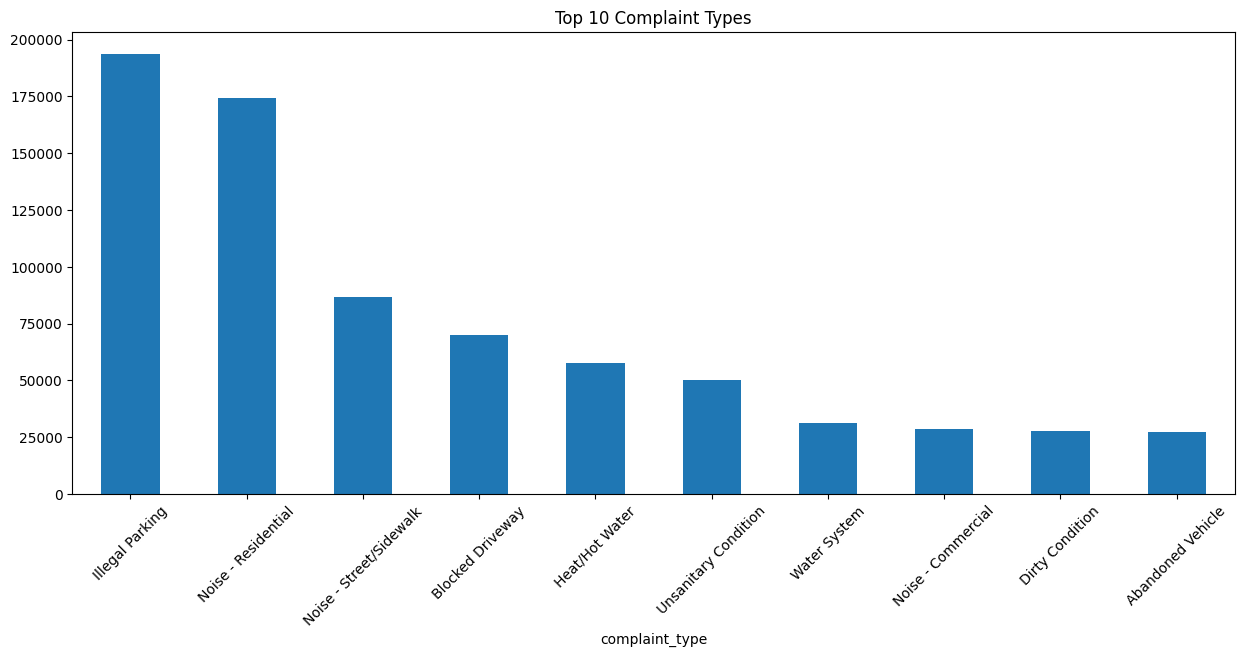

In [38]:
# Top complaints
plt.figure(figsize=(15,6))
df['complaint_type'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Complaint Types')
plt.xticks(rotation=45)
plt.show()

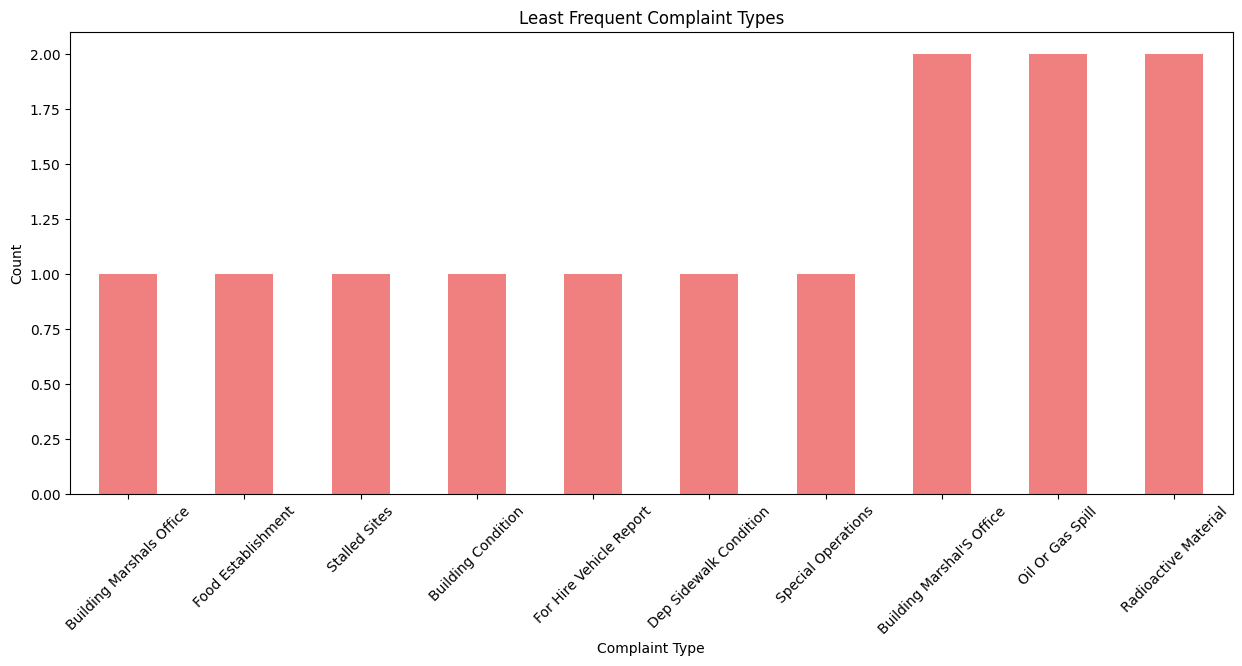

In [39]:
# Least frequent complaints
least_frequent_complaints = df['complaint_type'].value_counts(ascending=True).head(10)
least_frequent_complaints.plot(kind='bar', figsize=(15, 6), color='lightcoral', title='Least Frequent Complaint Types')
plt.xlabel('Complaint Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

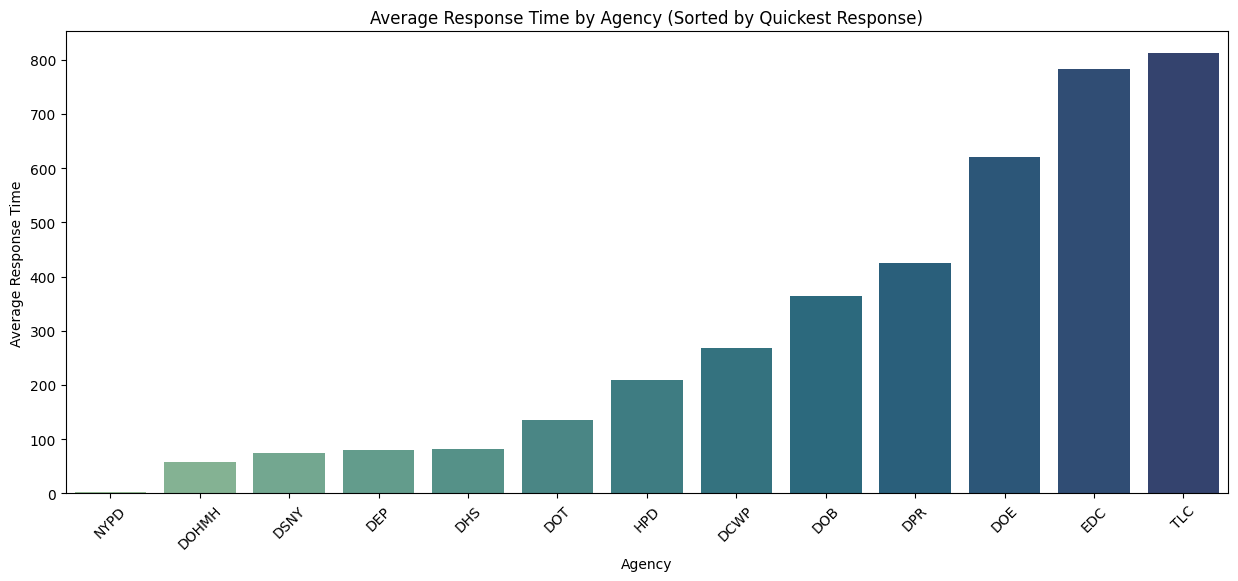

In [40]:
# Average response time by agency
agency_perf = df.groupby('agency')['response_time'].agg(['mean', 'count', 'std']).reset_index()
# Sort by mean response time in ascending order (quickest first)
agency_perf = agency_perf[agency_perf['count'] > 100].sort_values(by='mean', ascending=True)

# Plot the sorted average response times
plt.figure(figsize=(15, 6))
sns.barplot(data=agency_perf, x='agency', y='mean', order=agency_perf['agency'], palette="crest")
plt.xticks(rotation=45)
plt.title('Average Response Time by Agency (Sorted by Quickest Response)')
plt.xlabel('Agency')
plt.ylabel('Average Response Time')
plt.show()

In [41]:
df['borough'].value_counts()

borough
BROOKLYN         393060
QUEENS           309133
BRONX            296979
MANHATTAN        260969
STATEN ISLAND     46038
Name: count, dtype: int64

In [44]:
# Temporal features
df['hour'] = df['created_date'].dt.hour
df['day'] = df['created_date'].dt.day
df['month'] = df['created_date'].dt.month
df['day_of_week'] = df['created_date'].dt.dayofweek

Text(0.5, 1.0, 'Average Response Time by Month')

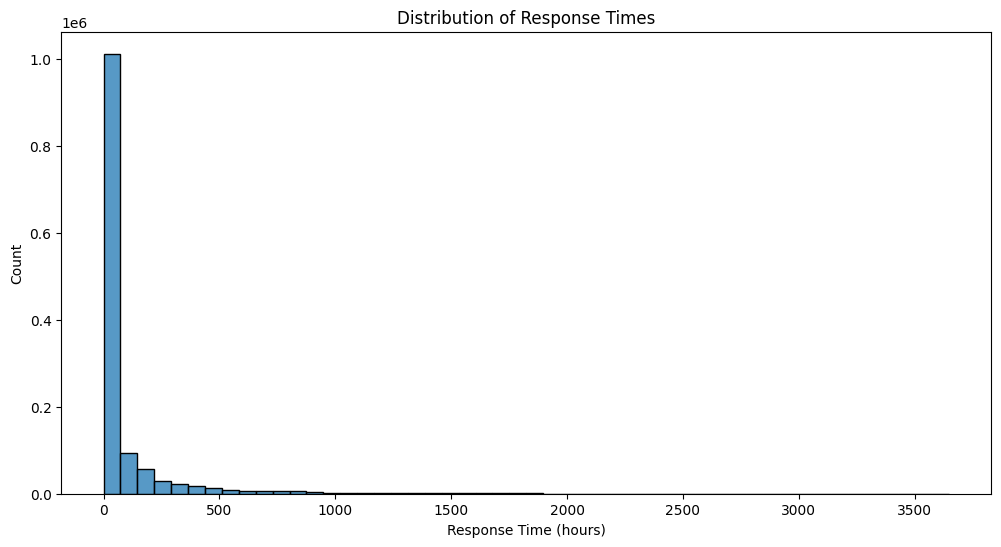

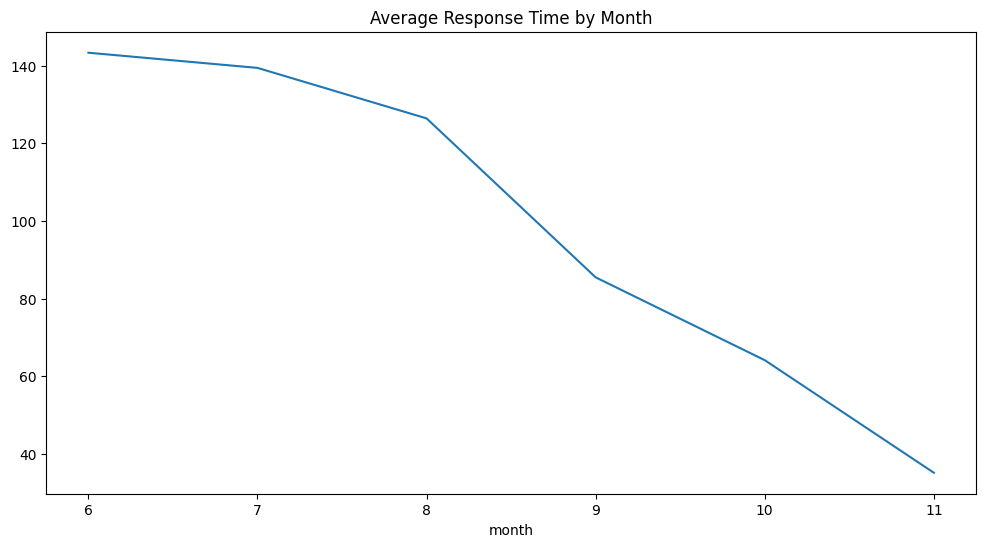

In [45]:
# Response time distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='response_time', bins=50)
plt.title('Distribution of Response Times')
plt.xlabel('Response Time (hours)')

# Monthly patterns
monthly_avg = df.groupby('month')['response_time'].mean()
plt.figure(figsize=(12, 6))
monthly_avg.plot(kind='line')
plt.title('Average Response Time by Month')

In [46]:
# Additional analysis functions
def get_top_complaints(df, n=10):
    """Analyze top complaint types"""
    complaint_counts = df["complaint_type"].value_counts().head(n)
    return complaint_counts


def calculate_response_times(df):
    """Calculate average response times"""
    df["response_time"] = (
        pd.to_datetime(df["closed_date"]) - pd.to_datetime(df["created_date"])
    ).dt.total_seconds() / 3600  # in hours
    return df["response_time"].describe()


Summary Statistics:
--------------------------------------------------
Total Complaints: 1,306,179
Time Period: 2024-06-26 to 2024-11-27

Complaints by Borough:
BROOKLYN: 393,060 (30.1%)
QUEENS: 309,133 (23.7%)
BRONX: 296,979 (22.7%)
MANHATTAN: 260,969 (20.0%)
STATEN ISLAND: 46,038 (3.5%)

Top 10 Complaint Types:
--------------------------------------------------
complaint_type
Illegal Parking            193688
Noise - Residential        174259
Noise - Street/Sidewalk     86674
Blocked Driveway            69991
Heat/Hot Water              57721
Unsanitary Condition        50082
Water System                31085
Noise - Commercial          28503
Dirty Condition             27489
Abandoned Vehicle           27266
Name: count, dtype: int64

Response Time Statistics (hours):
--------------------------------------------------
count    1.306179e+06
mean     9.382496e+01
std      2.565656e+02
min      0.000000e+00
25%      9.313889e-01
50%      4.969444e+00
75%      5.786667e+01
max      3.6

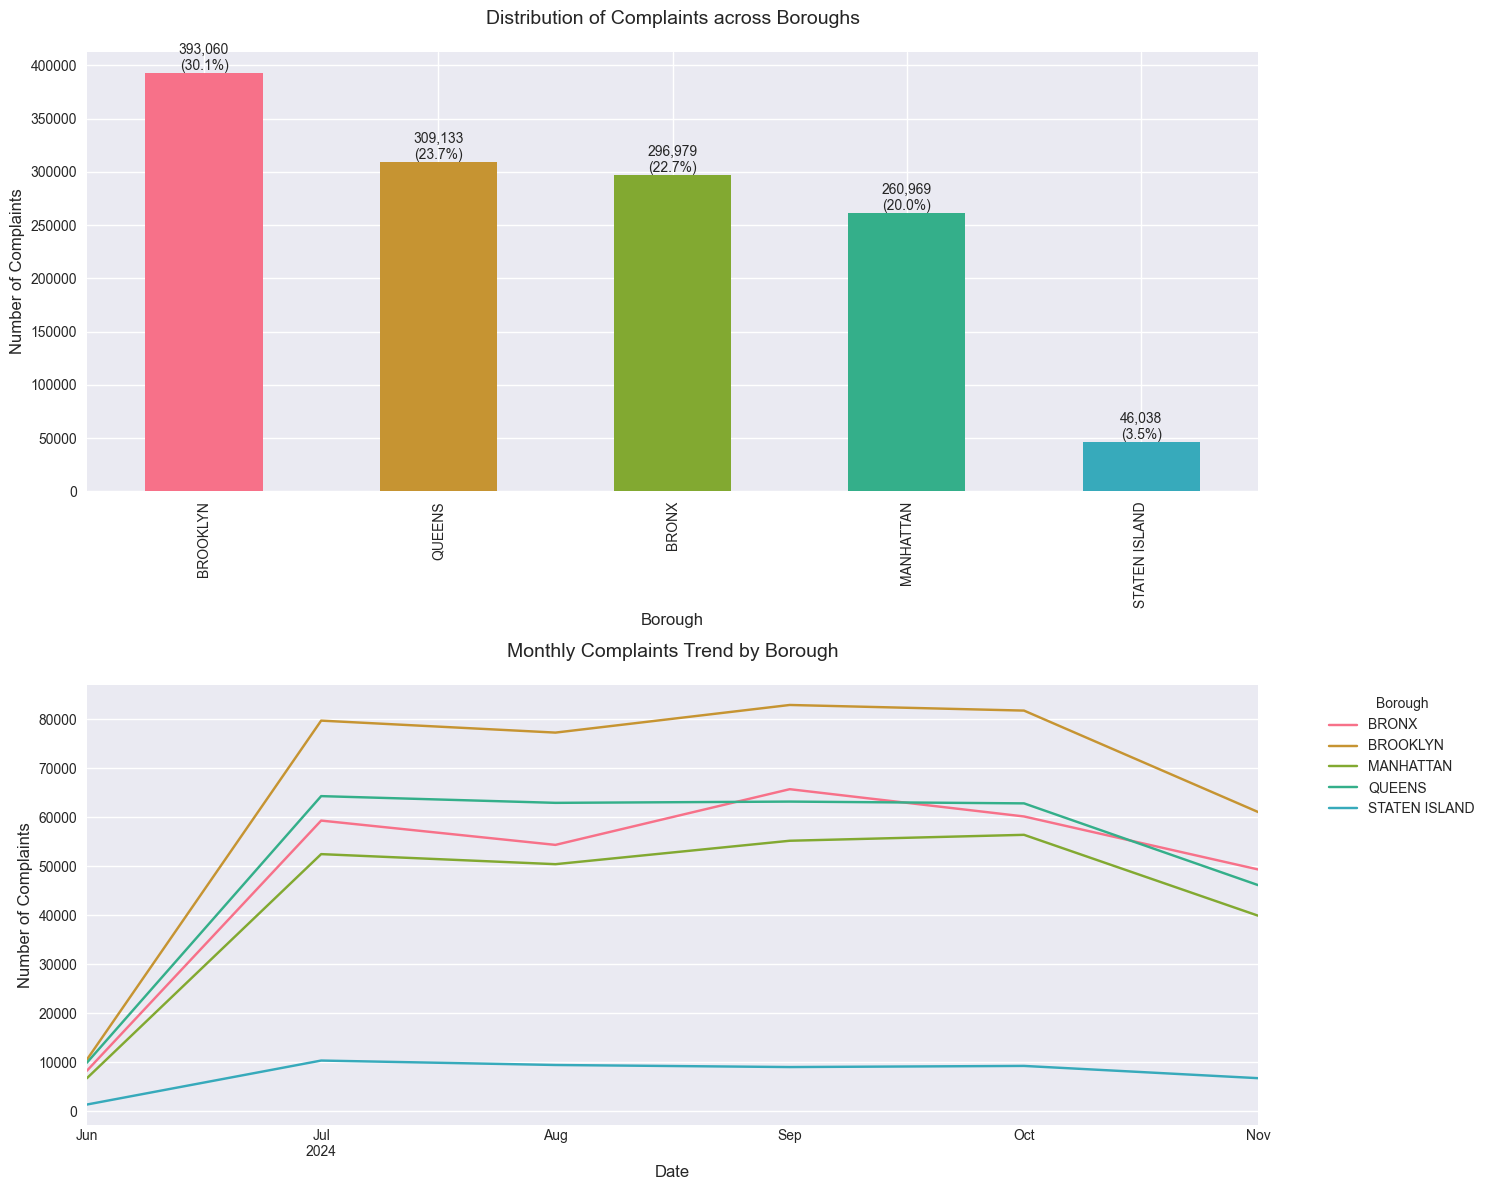

In [47]:
# Set the style
plt.style.use("seaborn-v0_8")

# Create figure with larger size and better resolution
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), dpi=100)

# Color palette
colors = sns.color_palette("husl", n_colors=7)

# Top plot: Borough distribution
borough_counts = df["borough"].value_counts()
borough_percentages = (borough_counts / len(df) * 100).round(1)

bars = borough_counts.plot(kind="bar", color=colors, ax=ax1)
ax1.set_title("Distribution of Complaints across Boroughs", pad=20, fontsize=14)
ax1.set_xlabel("Borough", fontsize=12)
ax1.set_ylabel("Number of Complaints", fontsize=12)

# Add value labels on top of each bar
for i, (count, percentage) in enumerate(zip(borough_counts, borough_percentages)):
    ax1.text(i, count, f"{count:,}\n({percentage}%)", ha="center", va="bottom")

# Bottom plot: Time series analysis by borough
df["created_date"] = pd.to_datetime(df["created_date"])
monthly_borough = (
    df.groupby([pd.Grouper(key="created_date", freq="M"), "borough"]).size().unstack()
)

# Plot time series
monthly_borough.plot(color=colors, ax=ax2)
ax2.set_title("Monthly Complaints Trend by Borough", pad=20, fontsize=14)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Number of Complaints", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
ax2.legend(title="Borough", bbox_to_anchor=(1.05, 1), loc="upper left")

# Adjust layout
plt.tight_layout()

# Add summary statistics
print("\nSummary Statistics:")
print("-" * 50)
print(f"Total Complaints: {len(df):,}")
print(    f"Time Period: {df['created_date'].min().strftime('%Y-%m-%d')} to {df['created_date'].max().strftime('%Y-%m-%d')}")
print("\nComplaints by Borough:")
for borough, count in borough_counts.items():
    print(f"{borough}: {count:,} ({borough_percentages[borough]}%)")

top_complaints = get_top_complaints(df)
print("\nTop 10 Complaint Types:")
print("-" * 50)
print(top_complaints)

# Calculate response times
response_times = calculate_response_times(df)
print("\nResponse Time Statistics (hours):")
print("-" * 50)
print(response_times)

**Geographic Distribution of Complaints:**
- Brooklyn leads with 30.1% of all complaints (393,060)
- Queens follows with 23.7% (309,133)
- Bronx and Manhattan are close with 22.7% and 20.0% respectively
- Staten Island has significantly fewer complaints (3.5%) - Worth noting that it is the smallest of the five boroughs so that could be why it has the least complaints
- This distribution roughly correlates with borough population sizes, but we should normalize by population for better insight

**Top Complaint Types:**
- Quality of life issues dominate:
  * Illegal Parking (193,688 complaints) is the most common
  * Noise-related complaints appear multiple times (Residential: 174,259, Street/Sidewalk: 86,674, Commercial: 28,503)
  * Essential services issues (Heat/Hot Water: 57,721, Water System: 31,085) are also significant
- This suggests resource allocation should prioritize parking enforcement and noise control

Deduction: Parking issues and noise complaints are recurring problems, while heat-related complaints may require proactive planning during winter months

**Response Time Analysis:**
- Median (50th percentile) response time is ~4.97 hours suggesting that while many complaints are resolved quickly, outliers skew the average.
- 75% of cases are resolved within ~55.9 hours
- Mean response time is ~93.8 hours (nearly 4 days) (higher than median indicating right-skewed distribution)
- Large standard deviation (256.6 hours) suggests high variability in response times
- Maximum response time is ~3,648 hours (approximately 152 days) - may reflect unresolved or exceptionally complex cases

**Recommendations:**
- **Resource Allocation:** 
  * Increase resources in Brooklyn and Queens proportionally
  * Focus on parking enforcement and noise control teams
  * Investigate why Staten Island has such low numbers (potential underreporting?)

- **Process Improvement:**
  * Investigate cases with extremely long response times (>75th percentile)
  * Address data quality issues (negative response times)
  * Consider separate SLAs for different complaint types


2. Monthly Trends by Borough
Complaint volumes show an upward trend during the summer months (June-July) and stabilize toward the fall (October-November).
Queens consistently has higher complaint volumes month-to-month, indicating a potentially higher demand for services.
Deduction: Seasonality likely impacts complaint volumes, possibly due to noise, outdoor activities, or heat-related issues in summer.

In [48]:
# Displaying countplot of some categorical variables
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Optional


def count_plots(
    df: pd.DataFrame,
    columns: Optional[List[str]] = None,
    max_unique_values: int = 30,
    min_count: int = 100,
    figsize: tuple = (12, 8),
    palette: str = 'viridis',
    title_fontsize: int = 16,
    label_fontsize: int = 12,
    rotation: int = 0,
    show_percentages: bool = True,
    top_n: Optional[int] = 20
) -> None:
    """
    Create enhanced count plots for categorical variables in the DataFrame.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input DataFrame
    columns : list of str, optional
        Specific columns to plot. If None, will analyze all columns
    max_unique_values : int
        Maximum number of unique values to consider a column categorical
    min_count : int
        Minimum count to include in the plot
    figsize : tuple
        Figure size for each plot
    palette : str
        Color palette to use
    title_fontsize : int
        Font size for plot titles
    label_fontsize : int
        Font size for axis labels
    rotation : int
        Rotation angle for x-axis labels
    show_percentages : bool
        Whether to show percentages alongside counts
    top_n : int, optional
        Number of top categories to show. If None, shows all categories
    """
    
    # Set the style
    plt.style.use('seaborn-v0_8')
    
    # If no columns specified, analyze all columns
    if columns is None:
        columns = df.columns
    
    for col in columns:
        # Check if column is categorical-like
        unique_values_count = df[col].nunique()
        if unique_values_count <= max_unique_values:
            # Calculate value counts and percentages
            value_counts = df[col].value_counts()
            
            # Filter by minimum count
            value_counts = value_counts[value_counts >= min_count]
            
            # Take top N if specified
            if top_n is not None:
                value_counts = value_counts.head(top_n)
            
            # Calculate percentages
            percentages = (value_counts / len(df) * 100).round(1)
            
            # Create figure
            fig, ax = plt.subplots(figsize=figsize)
            
            # Create horizontal bar plot
            bars = value_counts.plot(
                kind='barh',
                color=sns.color_palette(palette, n_colors=len(value_counts)),
                ax=ax
            )
            
            # Add value labels
            for i, (count, percentage) in enumerate(zip(value_counts, percentages)):
                ax.text(
                    count, 
                    i,
                    f'{count:,} ({percentage}%)' if show_percentages else f'{count:,}',
                    va='center',
                    ha='left',
                    fontsize=label_fontsize
                )
            
            # Customize the plot
            plt.title(f'Distribution of {col}', pad=20, fontsize=title_fontsize)
            plt.xlabel('Count', fontsize=label_fontsize)
            plt.ylabel(col, fontsize=label_fontsize)
            
            # Rotate labels if specified
            plt.xticks(rotation=rotation)
            
            # Add grid for better readability
            ax.grid(True, axis='x', alpha=0.3)
            
            # Remove top and right spines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            # Add summary statistics in the plot
            stats_text = (
                f'Total Records: {len(df):,}\n'
                f'Unique Values: {unique_values_count:,}\n'
                f'Most Common: {value_counts.index[0]}\n'
                f'Least Common: {value_counts.index[-1]}'
            )
            plt.text(
                0.95, 0.05,
                stats_text,
                transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.8),
                verticalalignment='bottom',
                horizontalalignment='right',
                fontsize=10
            )
            
            # Adjust layout and display
            plt.tight_layout()
            plt.show()
            
            # Print summary statistics
            print(f"\nSummary Statistics for {col}:")
            print("-" * 50)
            print(f"Total unique values: {unique_values_count}")
            print("\nTop 5 categories:")
            for idx, (category, count) in enumerate(value_counts.head().items(), 1):
                print(f"{idx}. {category}: {count:,} ({(count/len(df)*100):.1f}%)")

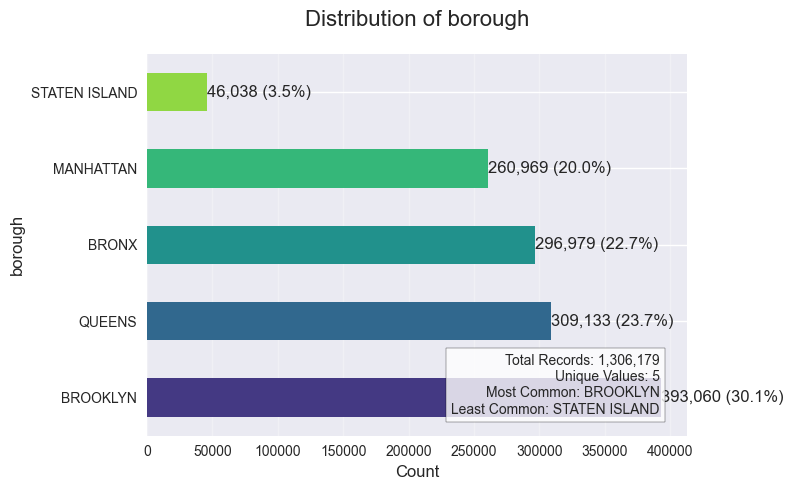


Summary Statistics for borough:
--------------------------------------------------
Total unique values: 5

Top 5 categories:
1. BROOKLYN: 393,060 (30.1%)
2. QUEENS: 309,133 (23.7%)
3. BRONX: 296,979 (22.7%)
4. MANHATTAN: 260,969 (20.0%)
5. STATEN ISLAND: 46,038 (3.5%)


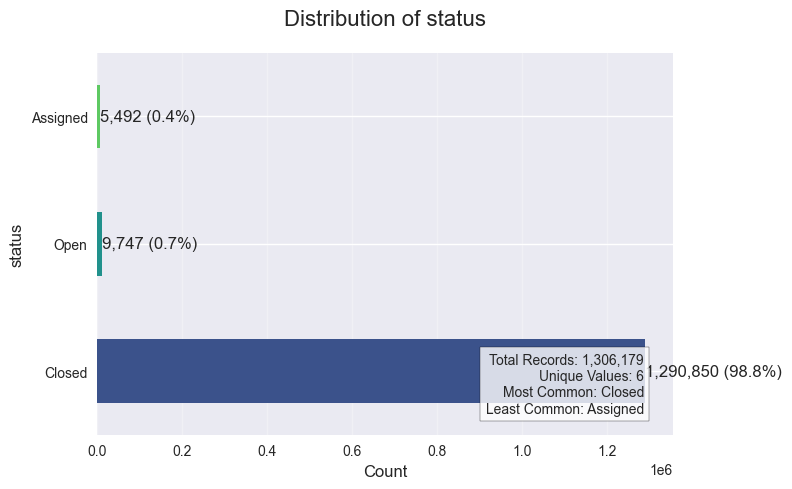


Summary Statistics for status:
--------------------------------------------------
Total unique values: 6

Top 5 categories:
1. Closed: 1,290,850 (98.8%)
2. Open: 9,747 (0.7%)
3. Assigned: 5,492 (0.4%)


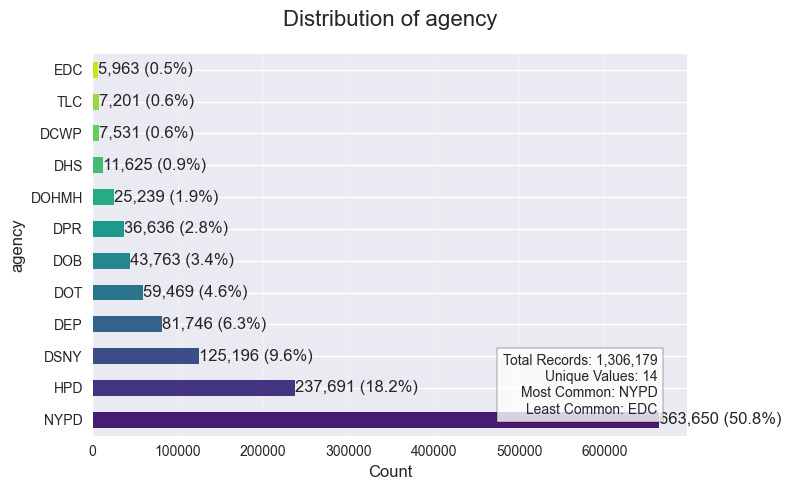


Summary Statistics for agency:
--------------------------------------------------
Total unique values: 14

Top 5 categories:
1. NYPD: 663,650 (50.8%)
2. HPD: 237,691 (18.2%)
3. DSNY: 125,196 (9.6%)
4. DEP: 81,746 (6.3%)
5. DOT: 59,469 (4.6%)


In [49]:
columns_to_analyze = ['complaint_type', 'borough', 'status', 'agency']
count_plots(
    df,
    columns=columns_to_analyze,
    max_unique_values=50,
    min_count=1000,
    figsize=(8, 5),
    palette='viridis',
    top_n=15
)

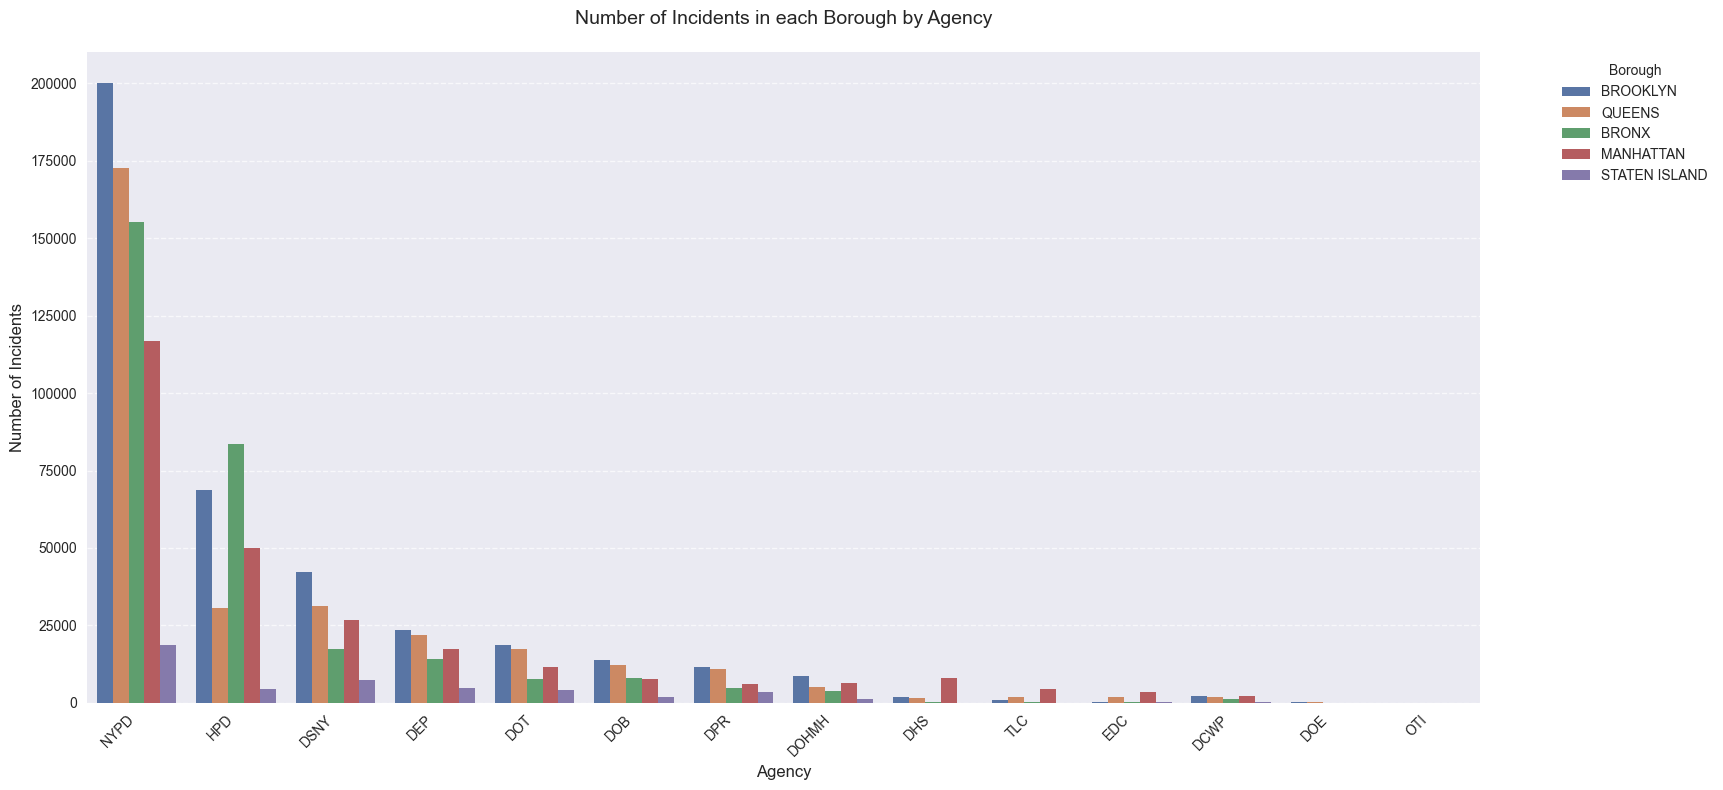

In [50]:
# Group and count incidents by agency and borough
agency_borough = df.groupby(['agency', 'borough']).size().reset_index(name='count')

# Sort by count in descending order
agency_borough = agency_borough.sort_values('count', ascending=False)

# Create a more visually appealing plot using seaborn
plt.figure(figsize=(15, 8))
sns.barplot(data=agency_borough, 
            x='agency', 
            y='count', 
            hue='borough',
            palette='deep')

# Customize the plot
plt.title('Number of Incidents in each Borough by Agency', pad=20, size=14)
plt.xlabel('Agency', size=12)
plt.ylabel('Number of Incidents', size=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Add legend in a better position
plt.legend(title='Borough', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

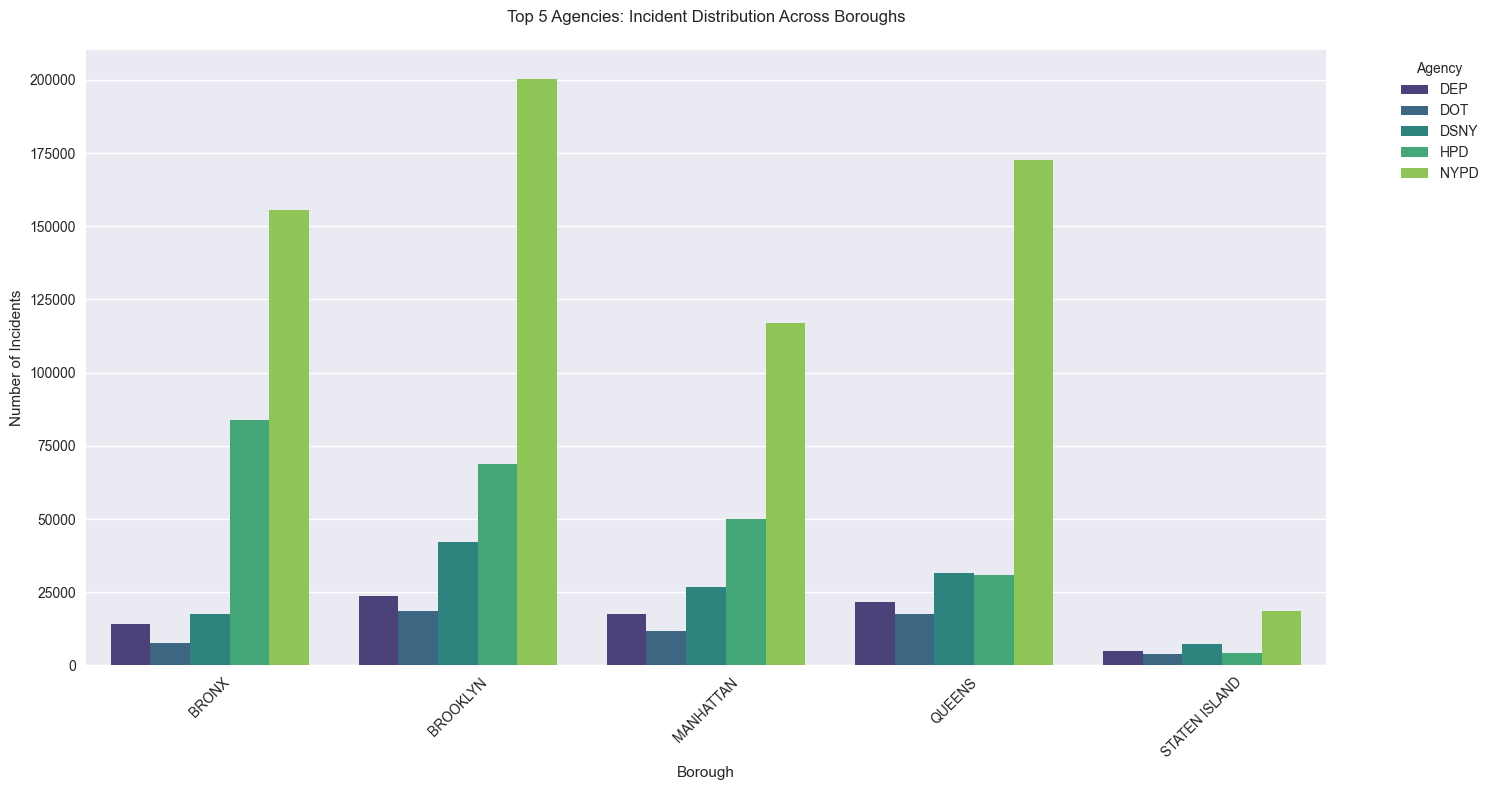


=== Business Insights ===

Top Agencies by Total Incidents:
       incident_count           percentage
                  sum      mean        sum
agency                                    
DEP             81746   16349.2       6.26
DOT             59469   11893.8       4.56
DSNY           125196   25039.2       9.59
HPD            237691   47538.2      18.18
NYPD           663650  132730.0      50.82

Borough-wise Incident Distribution:
borough
BROOKLYN         353620
BRONX            278277
QUEENS           274066
MANHATTAN        222853
STATEN ISLAND     38936
Name: incident_count, dtype: int64

Top Agency-Borough Combinations:
   agency    borough  incident_count  percentage
56   NYPD   BROOKLYN          200215       15.33
58   NYPD     QUEENS          172655       13.22
55   NYPD      BRONX          155404       11.90
57   NYPD  MANHATTAN          116855        8.95
50    HPD      BRONX           83654        6.40


In [51]:
# Group and count incidents
agency_borough_counts = df.groupby(['agency', 'borough'])['complaint_type'].count().reset_index(name='incident_count')

# Calculate percentage of total incidents for each agency
total_incidents = agency_borough_counts['incident_count'].sum()
agency_borough_counts['percentage'] = (agency_borough_counts['incident_count'] / total_incidents * 100).round(2)

# Get top agencies by incident count
top_agencies = agency_borough_counts.groupby('agency')['incident_count'].sum().nlargest(5).index
filtered_data = agency_borough_counts[agency_borough_counts['agency'].isin(top_agencies)]

# Create visualization
plt.figure(figsize=(15, 8))
sns.barplot(x='borough', 
            y='incident_count',
            hue='agency',
            data=filtered_data,
            palette='viridis')

plt.title('Top 5 Agencies: Incident Distribution Across Boroughs', pad=20)
plt.xlabel('Borough')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.legend(title='Agency', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Generate and print insights
# Agency-wide statistics
agency_stats = filtered_data.groupby('agency').agg({
    'incident_count': ['sum', 'mean'],
    'percentage': 'sum'
}).round(2)

# Borough-wide statistics
borough_stats = filtered_data.groupby('borough')['incident_count'].sum().sort_values(ascending=False)

# Find highest incident combinations
top_combinations = filtered_data.nlargest(5, 'incident_count')

print("\n=== Business Insights ===")
print("\nTop Agencies by Total Incidents:")
print(agency_stats)

print("\nBorough-wise Incident Distribution:")
print(borough_stats)

print("\nTop Agency-Borough Combinations:")
print(top_combinations[['agency', 'borough', 'incident_count', 'percentage']])

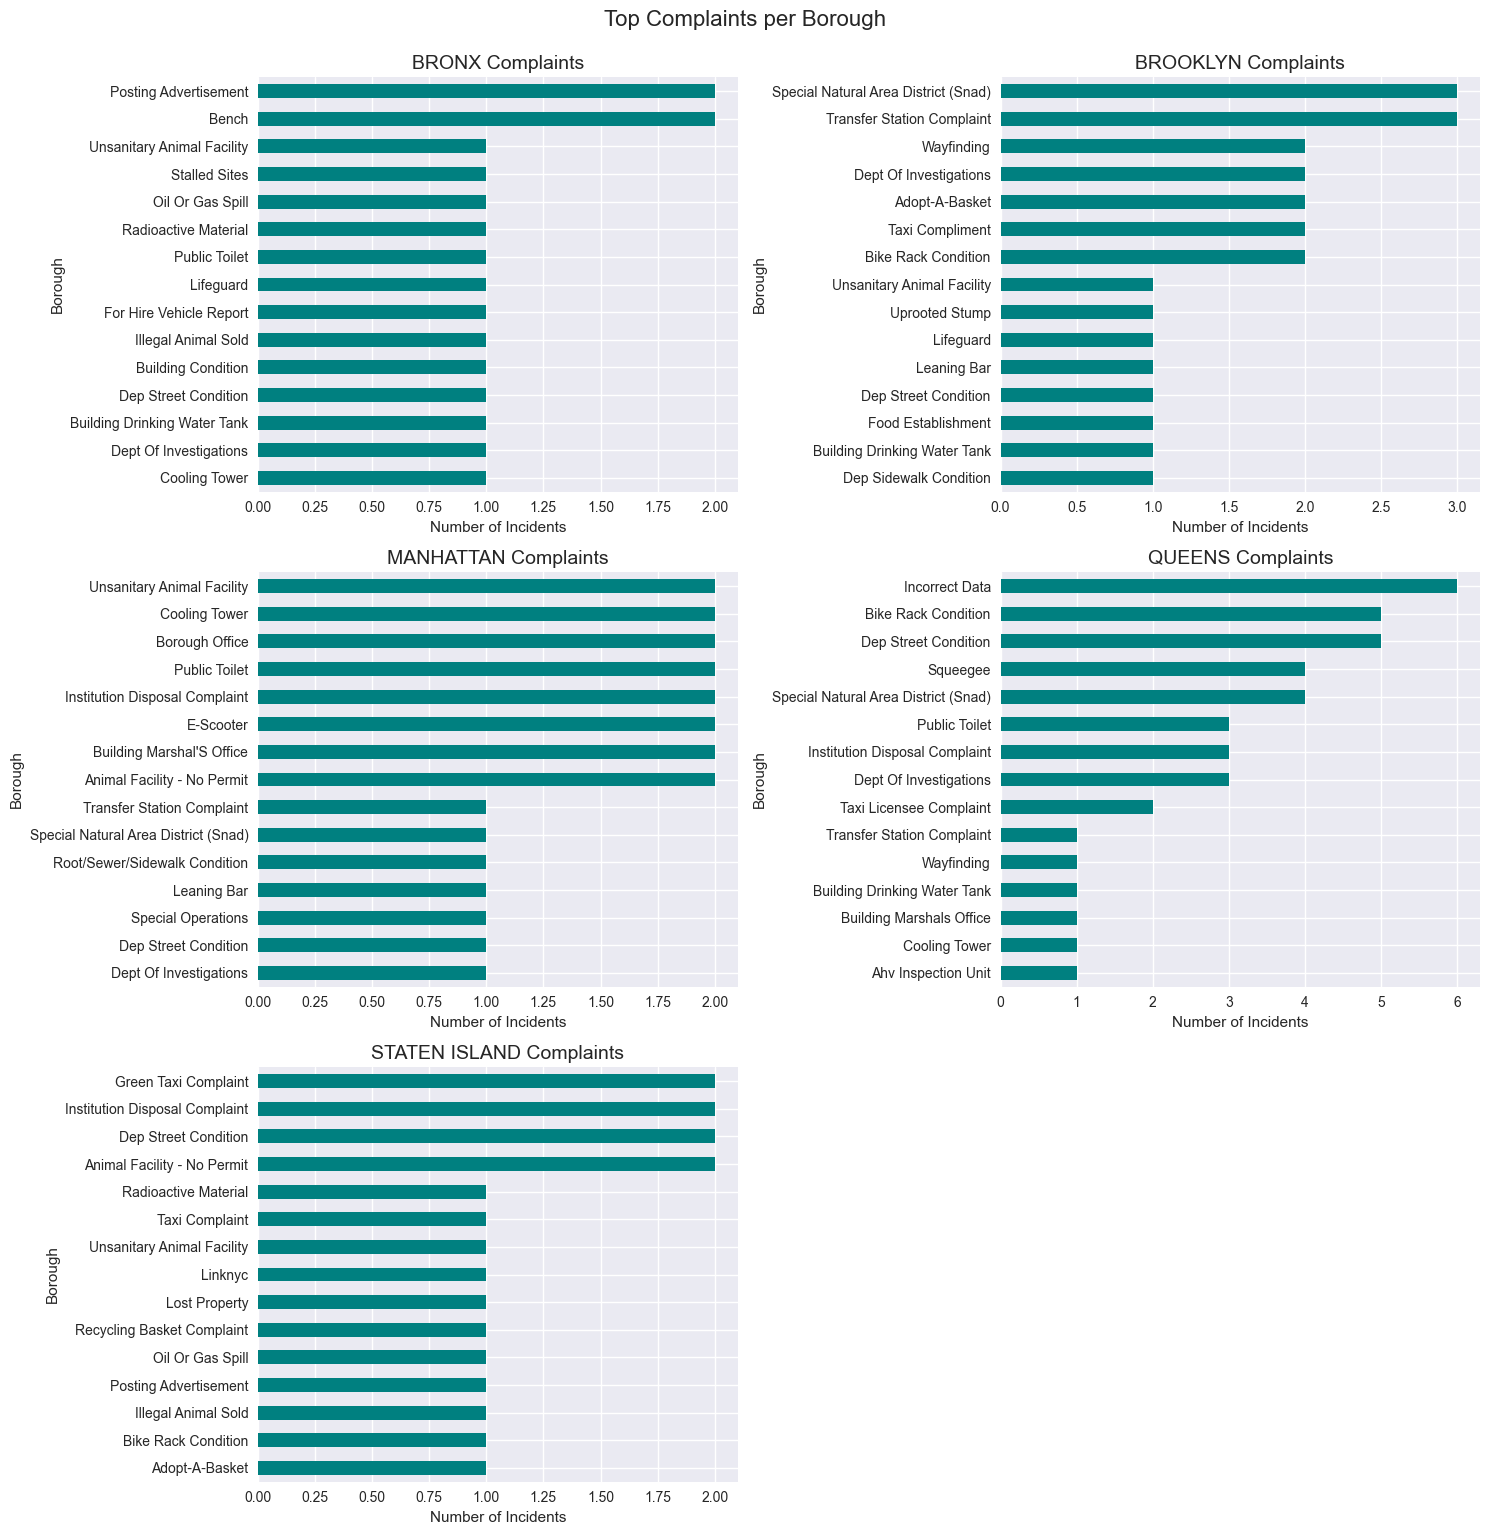

In [52]:
# Visualization of most complaints per borough (additional analysis)
borough_comp = df.groupby(['complaint_type', 'borough']).size().unstack()

# Adjust the number of columns and rows based on the number of subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # 3 rows, 2 columns layout

# Flatten the 2D array of axes for easier iteration
axes = axes.flatten()

# Loop through the columns and plot each subplot
for i, (label, col) in enumerate(borough_comp.items()):
    if i >= len(axes):  # Break the loop if there are no more subplots to plot
        break
    col = col.sort_values(ascending=True)[:15]  # Display only the top 15 for clarity
    ax = axes[i]
    col.plot(kind='barh', ax=ax, color='teal')
    ax.set_title(f'{label} Complaints', fontsize=14)
    ax.set_xlabel('Number of Incidents')
    ax.set_ylabel('Borough')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle('Top Complaints per Borough', fontsize=16, y=1.02)
plt.show()

- There are clear differences in incident volumes between the various agencies, with `NYPD` being the dominant agency in terms of incident response across all boroughs
- HPD and DSNY also report substantial incident numbers, especially in boroughs like Brooklyn and Queens
- The boroughs with the highest overall incident counts are Brooklyn, Queens, and the Bronx, while Manhattan and Staten Island have relatively lower incident counts



Location Type Analysis 
--------------------------------------------------
Total number of complaints: 1,306,179
Number of unique location types: 7

Top 10 Location Types:
1. Street: 609,111 (46.6%)
2. Residential: 445,406 (34.1%)
3. Other: 176,852 (13.5%)
4. Commercial: 33,932 (2.6%)
5. Public Space: 22,683 (1.7%)
6. Food & Entertainment: 13,610 (1.0%)
7. Mixed Use: 4,585 (0.3%)

Location Type Analysis for Brooklyn
--------------------------------------------------
Total number of complaints: 393,060
Number of unique location types: 7

Top 10 Location Types:
1. Street: 197,230 (50.2%)
2. Residential: 120,403 (30.6%)
3. Other: 51,138 (13.0%)
4. Commercial: 9,856 (2.5%)
5. Public Space: 7,473 (1.9%)
6. Food & Entertainment: 4,915 (1.2%)
7. Mixed Use: 2,045 (0.5%)

Response Time by Location Type (hours)
--------------------------------------------------
                            mean      median   count
location_type                                       
Street                 47.764

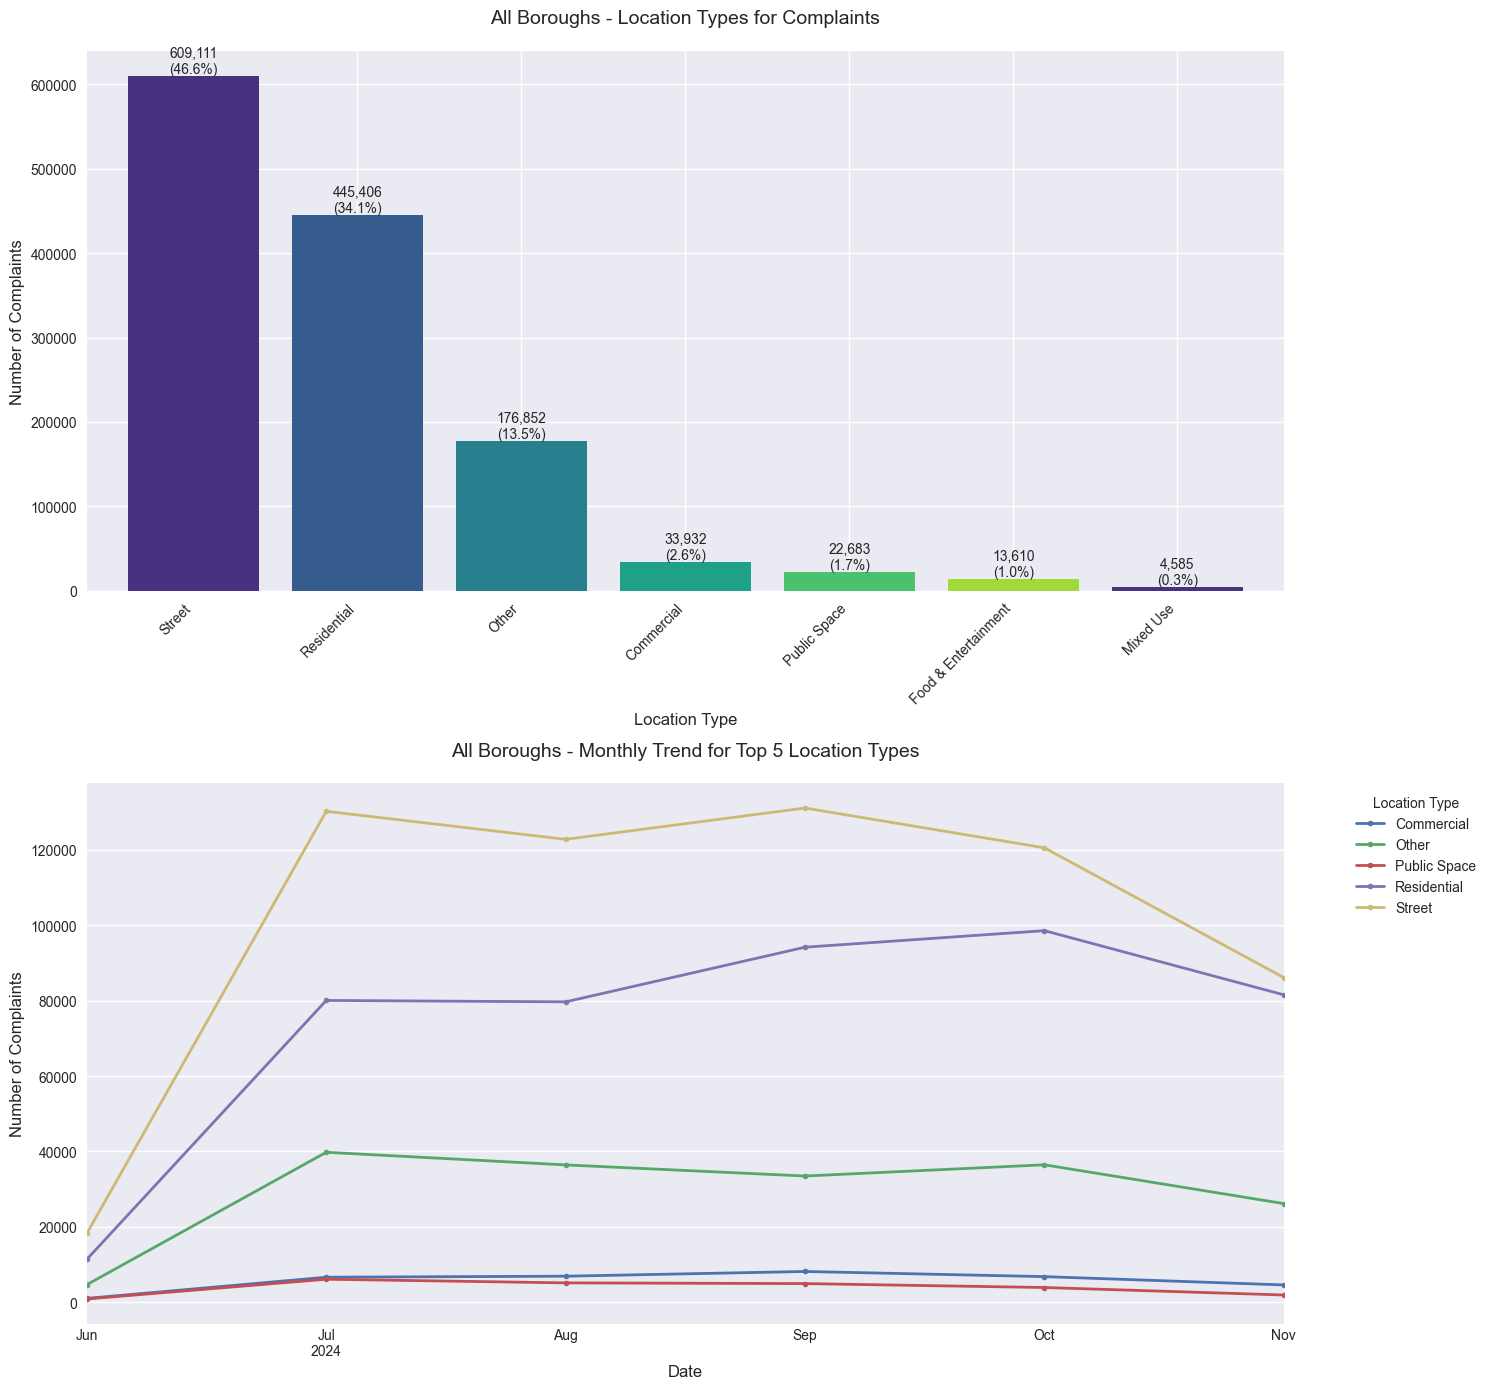

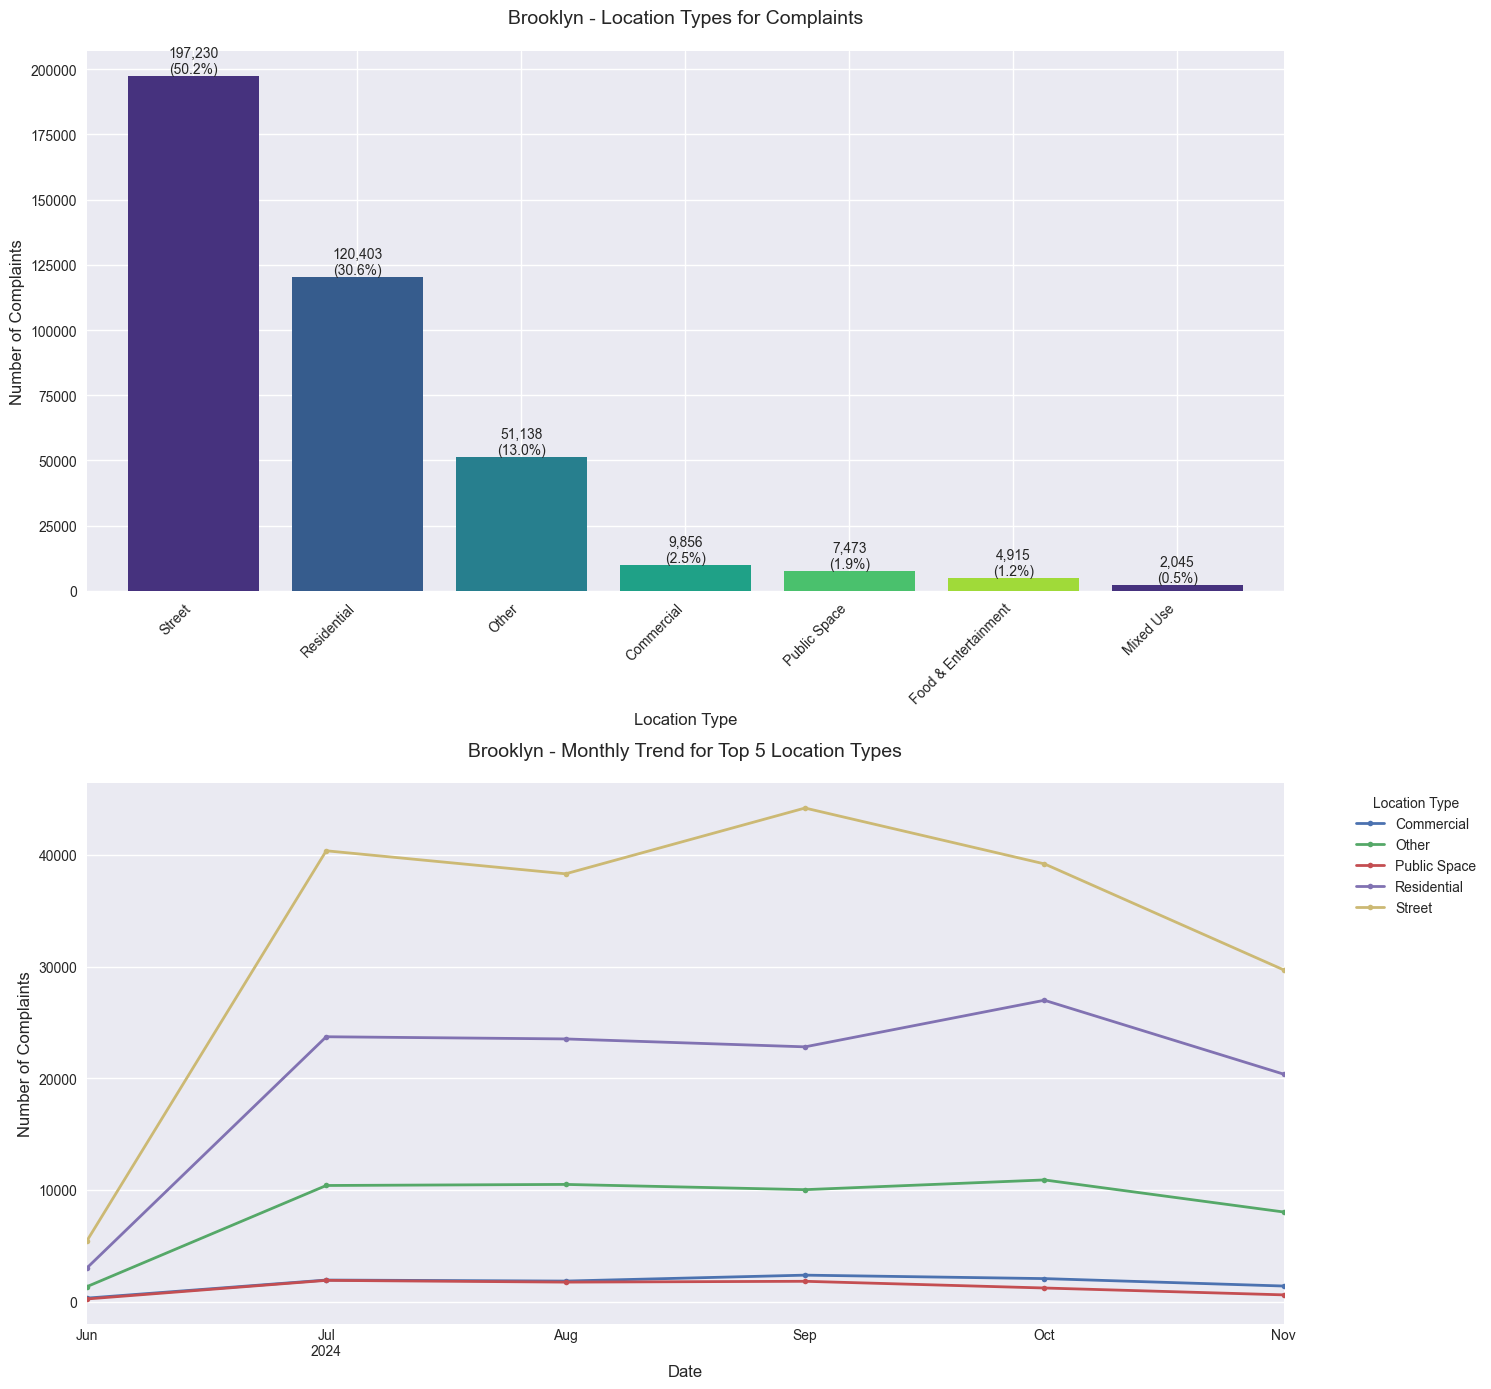

In [53]:
def analyze_location_types(df, borough=None):
    """
    Analyze and visualize location types for complaints

    Parameters:
    -----------
    df : pandas DataFrame
        The input DataFrame containing the complaint data
    borough : str, optional
        Specific borough to analyze (default: None, analyzes all boroughs)
    top_n : int, optional
        Number of top location types to display (default: 25)
    """

    # Set style
    plt.style.use("seaborn-v0_8")

    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 14), dpi=100)

    # Filter for specific borough if specified
    if borough:
        df = df[df["borough"] == borough.upper()]
        title_prefix = f"{borough} - "
    else:
        title_prefix = "All Boroughs - "

    # Get location type counts and percentages
    location_counts = df["location_type"].value_counts()
    location_percentages = (location_counts / len(df) * 100).round(2)

    # Get top N location types
    top_locations = location_counts # .head(top_n)
    top_percentages = location_percentages # .head(top_n)

    # Colors
    colors = sns.color_palette("viridis")

    # Plot 1: Bar chart
    bars = top_locations.plot(kind="bar", color=colors, ax=ax1, width=0.8)

    # Customize first plot
    ax1.set_title(
        f"{title_prefix}Location Types for Complaints", pad=20, fontsize=14
    )
    ax1.set_xlabel("Location Type", fontsize=12)
    ax1.set_ylabel("Number of Complaints", fontsize=12)

    # Add value labels on bars
    for i, (count, percentage) in enumerate(zip(top_locations, top_percentages)):
        ax1.text(
            i,
            count,
            f"{count:,}\n({percentage:.1f}%)",
            ha="center",
            va="bottom",
            fontsize=10,
        )

    # Rotate x-axis labels
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

    # Plot 2: Time trend for top 5 location types
    top_5_locations = location_counts.head(5).index
    df["created_date"] = pd.to_datetime(df["created_date"])

    # Create monthly trends for top 5 locations
    monthly_locations = (
        df[df["location_type"].isin(top_5_locations)]
        .groupby([pd.Grouper(key="created_date", freq="M"), "location_type"])
        .size()
        .unstack()
    )

    # Plot time series
    monthly_locations.plot(ax=ax2, marker="o", markersize=4, linewidth=2)

    # Customize second plot
    ax2.set_title(
        f"{title_prefix}Monthly Trend for Top 5 Location Types", pad=20, fontsize=14
    )
    ax2.set_xlabel("Date", fontsize=12)
    ax2.set_ylabel("Number of Complaints", fontsize=12)

    # Rotate x-axis labels
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="right")

    # Add legend
    ax2.legend(title="Location Type", bbox_to_anchor=(1.05, 1), loc="upper left")

    # Adjust layout
    plt.tight_layout()

    # Print summary statistics
    print(f"\nLocation Type Analysis {f'for {borough}' if borough else ''}")
    print("-" * 50)
    print(f"Total number of complaints: {len(df):,}")
    print(f"Number of unique location types: {len(location_counts):,}")
    print("\nTop 10 Location Types:")
    for loc, (count, pct) in enumerate(
        zip(location_counts.head(10), location_percentages.head(10)), 1
    ):
        print(f"{loc}. {location_counts.index[loc-1]}: {count:,} ({pct:.1f}%)")

    return fig


# For all boroughs
fig_all = analyze_location_types(df)

# For specific borough
fig_brooklyn = analyze_location_types(df, borough="Brooklyn")

# Location type correlation with response time
def analyze_response_by_location(df):
    df["response_time"] = (
        pd.to_datetime(df["closed_date"]) - pd.to_datetime(df["created_date"])
    ).dt.total_seconds() / 3600

    location_response = (
        df.groupby("location_type")["response_time"]
        .agg(["mean", "median", "count"])
        .sort_values("count", ascending=False)
    )

    location_response = location_response[
        location_response["count"] > 100
    ]  # Filter for significance

    print("\nResponse Time by Location Type (hours)")
    print("-" * 50)
    print(location_response.head(10))

    return location_response


response_analysis = analyze_response_by_location(df)

In [54]:
df.columns

Index(['unique_key', 'created_date', 'agency', 'agency_name', 'complaint_type',
       'descriptor', 'location_type', 'incident_zip', 'incident_address',
       'street_name', 'address_type', 'city', 'facility_type', 'status',
       'due_date', 'resolution_description', 'resolution_action_updated_date',
       'community_board', 'bbl', 'borough', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'latitude', 'longitude',
       'location', ':@computed_region_efsh_h5xi',
       ':@computed_region_f5dn_yrer', ':@computed_region_yeji_bk3q',
       ':@computed_region_92fq_4b7q', ':@computed_region_sbqj_enih',
       ':@computed_region_7mpf_4k6g', 'closed_date', 'cross_street_1',
       'cross_street_2', 'intersection_street_1', 'intersection_street_2',
       'landmark', 'bridge_highway_name', 'bridge_highway_segment',
       'vehicle_type', 'bridge_highway_direction', 'taxi_pick_up_location',
       'taxi_

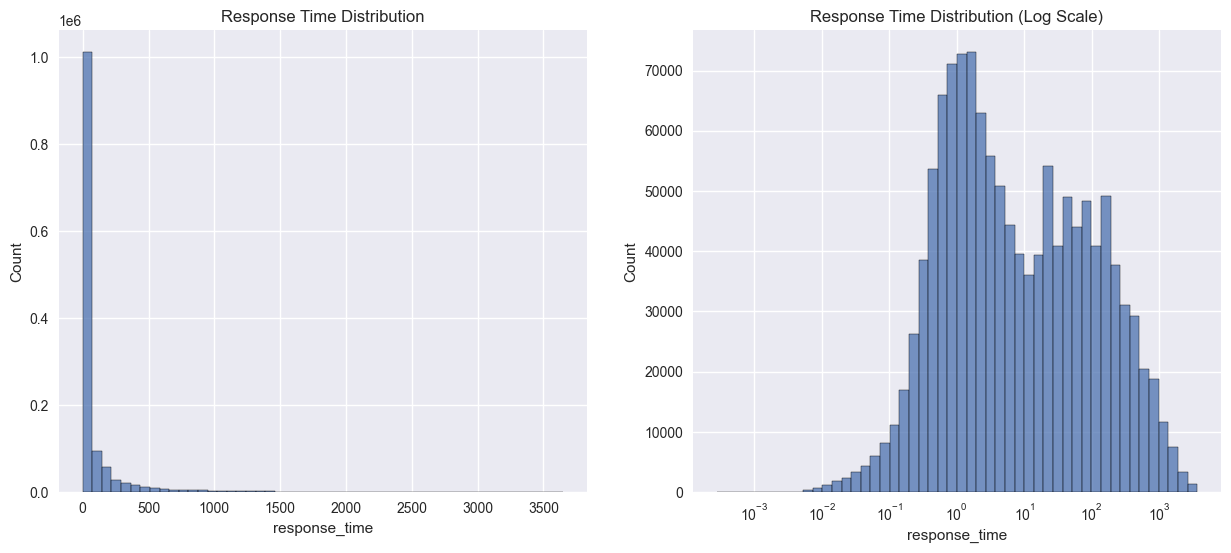

In [55]:
# Analyze response time patterns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(data=df, x='response_time', bins=50, ax=ax1)
ax1.set_title('Response Time Distribution')

# Log transform for better visualization
sns.histplot(data=df, x='response_time', bins=50, log_scale=True, ax=ax2)
ax2.set_title('Response Time Distribution (Log Scale)')

response_stats = df['response_time'].describe()

In [56]:
response_stats

count    1.306179e+06
mean     9.382496e+01
std      2.565656e+02
min      0.000000e+00
25%      9.313889e-01
50%      4.969444e+00
75%      5.786667e+01
max      3.648528e+03
Name: response_time, dtype: float64

In [71]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy import stats


def engineer_features(df):
    """
    Feature engineering function
    """
    df_processed = df.copy()

    # Transform Response Time (Target Variable)
    df_processed["response_time_log"] = np.log1p(df_processed["response_time"])
    df_processed["response_time_sqrt"] = np.sqrt(df_processed["response_time"])

    # Temporal Features
    df_processed["created_date"] = pd.to_datetime(df_processed["created_date"])
    df_processed["closed_date"] = pd.to_datetime(df_processed["closed_date"])

    # Extract time-based features
    df_processed["created_hour"] = df_processed["created_date"].dt.hour
    df_processed["created_day"] = df_processed["created_date"].dt.day
    df_processed["created_month"] = df_processed["created_date"].dt.month
    df_processed["created_year"] = df_processed["created_date"].dt.year
    df_processed["created_dayofweek"] = df_processed["created_date"].dt.dayofweek
    df_processed["created_quarter"] = df_processed["created_date"].dt.quarter

    # Is weekend feature
    df_processed["is_weekend"] = (
        df_processed["created_dayofweek"].isin([5, 6]).astype(int)
    )

    # Time of day categories
    df_processed["time_of_day"] = pd.cut(
        df_processed["created_hour"],
        bins=[0, 6, 12, 18, 24],
        labels=["Night", "Morning", "Afternoon", "Evening"],
    )

    df_processed["latitude"] = pd.to_numeric(df_processed["latitude"], errors="coerce")
    df_processed["longitude"] = pd.to_numeric(
        df_processed["longitude"], errors="coerce"
    )

    # Location-based Features
    # Calculate distance from city center (Manhattan)
    manhattan_coords = (40.7831, -73.9712)

    def haversine_distance(lat, lon, center=manhattan_coords):
        R = 6371  # Earth's radius in kilometers

        lat1, lon1 = np.radians([center[0], center[1]])
        lat2, lon2 = np.radians([lat, lon])

        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
        c = 2 * np.arcsin(np.sqrt(a))

        return R * c

    # Apply distance calculation
    mask = df_processed["latitude"].notna() & df_processed["longitude"].notna()
    df_processed.loc[mask, "distance_to_center"] = df_processed[mask].apply(
        lambda x: haversine_distance(x["latitude"], x["longitude"]), axis=1
    )

    # Categorical Features Engineering
    # Complaint type frequency encoding
    complaint_freq = df_processed["complaint_type"].value_counts(normalize=True)
    df_processed["complaint_frequency"] = df_processed["complaint_type"].map(
        complaint_freq
    )

    # Borough frequency encoding
    borough_freq = df_processed["borough"].value_counts(normalize=True)
    df_processed["borough_frequency"] = df_processed["borough"].map(borough_freq)

    # Historical Features
    # Average response time by complaint type
    avg_response_by_complaint = df_processed.groupby("complaint_type")[
        "response_time"
    ].mean()
    df_processed["avg_response_complaint"] = df_processed["complaint_type"].map(
        avg_response_by_complaint
    )

    # Average response time by borough
    avg_response_by_borough = df_processed.groupby("borough")["response_time"].mean()
    df_processed["avg_response_borough"] = df_processed["borough"].map(
        avg_response_by_borough
    )

    # # Interaction Features
    # df_processed["borough_complaint"] = (
    #     df_processed["borough"] + "_" + df_processed["complaint_type"]
    # )

    # Text-based Features (if applicable)
    if "descriptor" in df_processed.columns:
        df_processed["descriptor_length"] = (
            df_processed["descriptor"].fillna("").str.len()
        )

    # Binning Features
    df_processed["response_time_bins"] = pd.qcut(
        df_processed["response_time"],
        q=5,
        labels=["Very Fast", "Fast", "Medium", "Slow", "Very Slow"],
    )

    # Handle Missing Values
    numeric_columns = df_processed.select_dtypes(include=["float64", "int64"]).columns
    df_processed[numeric_columns] = df_processed[numeric_columns].fillna(
        df_processed[numeric_columns].mean()
    )

    # Feature Scaling (for numeric features)
    # scaler = StandardScaler()
    # numeric_cols = ["distance_to_center", "complaint_frequency", "borough_frequency"]
    # df_processed[numeric_cols] = scaler.fit_transform(df_processed[numeric_cols])

    return df_processed


In [72]:
# Apply feature engineering
df_engineered = engineer_features(df)

In [61]:
df_engineered.columns

Index(['unique_key', 'created_date', 'agency', 'agency_name', 'complaint_type',
       'descriptor', 'location_type', 'incident_zip', 'incident_address',
       'street_name', 'address_type', 'city', 'facility_type', 'status',
       'due_date', 'resolution_description', 'resolution_action_updated_date',
       'community_board', 'bbl', 'borough', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'latitude', 'longitude',
       'location', ':@computed_region_efsh_h5xi',
       ':@computed_region_f5dn_yrer', ':@computed_region_yeji_bk3q',
       ':@computed_region_92fq_4b7q', ':@computed_region_sbqj_enih',
       ':@computed_region_7mpf_4k6g', 'closed_date', 'cross_street_1',
       'cross_street_2', 'intersection_street_1', 'intersection_street_2',
       'landmark', 'bridge_highway_name', 'bridge_highway_segment',
       'vehicle_type', 'bridge_highway_direction', 'taxi_pick_up_location',
       'taxi_

In [73]:
df_engineered['incident_zip'].astype(str).str[:3].value_counts()

incident_zip
112    393070
104    297793
100    254373
113    151294
114    104438
103     46038
111     38388
116     13537
101      4477
110      1466
102      1283
123        17
83          4
108         1
Name: count, dtype: int64

In [74]:
def transform_response_time(df):
    """
    Apply various transformations to response time and select the best one.
    Returns the transformed data, transformation name, and inverse transformation function.
    """
    transformations = {
        'original': (
            df['response_time'],
            lambda x: x
        ),
        'log': (
            np.log1p(df['response_time']),
            lambda x: np.expm1(x)
        ),
        'sqrt': (
            np.sqrt(df['response_time']),
            lambda x: np.square(x)
        ),
        'box-cox': (
            stats.boxcox(df['response_time'] + 1)[0],
            lambda x, lmbda=stats.boxcox(df['response_time'] + 1)[1]: 
                (np.exp(np.log(x * lmbda + 1) / lmbda) if lmbda != 0 
                 else np.exp(x)) - 1
        )
    }
    
    # Calculate skewness for each transformation
    skewness = {name: stats.skew(trans[0]) for name, trans in transformations.items()}
    
    # Select transformation with lowest absolute skewness
    best_transform = min(skewness.items(), key=lambda x: abs(x[1]))[0]
    
    return (transformations[best_transform][0],
            best_transform,
            transformations[best_transform][1])

In [75]:
# Transform response time
transformed_response_time, transform_method, inverse_func  = transform_response_time(df)
df_engineered['response_time_transformed'] = transformed_response_time

In [76]:
print(f"Best transformation method for response time: {transform_method}")
print("\nNew features created:")
new_features = set(df_engineered.columns) - set(df.columns)
for feature in new_features:
    print(f"- {feature}")

Best transformation method for response time: box-cox

New features created:
- avg_response_complaint
- descriptor_length
- created_quarter
- response_time_sqrt
- created_month
- is_weekend
- created_year
- distance_to_center
- created_day
- response_time_transformed
- borough_frequency
- created_hour
- time_of_day
- complaint_frequency
- response_time_bins
- avg_response_borough
- created_dayofweek
- response_time_log


In [77]:
# Print basic statistics of transformed response time
print("\nTransformed Response Time Statistics:")
print(df_engineered['response_time_transformed'].describe())


Transformed Response Time Statistics:
count    1.306179e+06
mean     1.669963e+00
std      1.143144e+00
min      0.000000e+00
25%      6.148358e-01
50%      1.490154e+00
75%      2.739957e+00
max      3.915162e+00
Name: response_time_transformed, dtype: float64


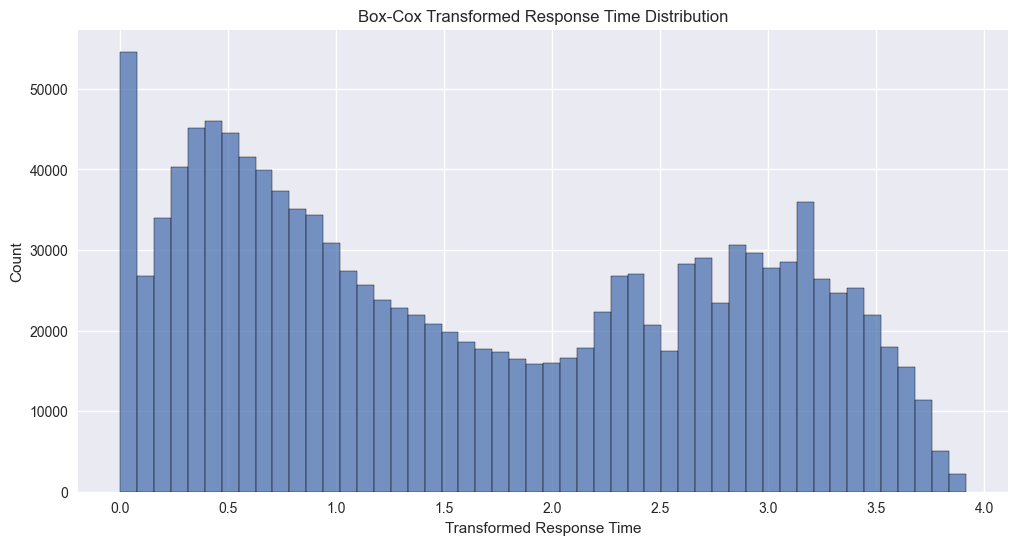

In [78]:
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.histplot(data=df_engineered, x='response_time_transformed', bins=50, ax=ax1)
ax1.set_title('Box-Cox Transformed Response Time Distribution')
ax1.set_xlabel('Transformed Response Time')
ax1.set_ylabel('Count')

plt.show()

- The transformed data seems to have a skewed distribution with a high frequency around lower values, gradually tapering off as the response time increases. It resembles a right-skewed distribution but is more symmetrical than the original response time data, indicating that the transformation worked to stabilize variance and normalize the distribution

- The plot has a concentration of counts near zero and gradually decreases as values increase, suggesting that the data is more spread out in the lower range of the transformed response time

- This distribution doesn't show extreme outliers as prominently as the non-transformed dataset did. The transformation seems to have helped mitigate the effect of extreme values

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Data Preparation
df_model = df_engineered[df_engineered['status'] == 'Closed'].copy()
df_model['created_date'] = pd.to_datetime(df_model['created_date'])

# Feature Selection
features_to_use = [
    'complaint_type',
    'borough',
    'created_hour',
    'is_weekend',
    'time_of_day',
    'distance_to_center',
    'borough_frequency',
    'avg_response_borough',
    'complaint_frequency',
    'created_dayofweek'
]

# Prepare features
# Handle complaint types (focus on top complaints that make up 80% of data)
complaint_counts = df_model['complaint_type'].value_counts()
top_complaints = complaint_counts[complaint_counts.cumsum() / complaint_counts.sum() <= 0.8].index
df_model['complaint_type'] = df_model['complaint_type'].apply(lambda x: x if x in top_complaints else 'Other')

# Create dummy variables for key categorical features
df_model = pd.get_dummies(df_model, 
                         columns=['complaint_type', 'borough', 'time_of_day'],
                         drop_first=True)

# Select features and target
X = df_model[df_model.columns[df_model.columns.isin(features_to_use) | 
                             df_model.columns.str.startswith(('complaint_type_', 'borough_', 'time_of_day_'))]]
y = df_model['response_time_transformed']

# Split data chronologically
train_size = 0.8
split_idx = int(len(df_model) * train_size)
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

# Scale numerical features
numerical_features = ['distance_to_center', 'borough_frequency', 'avg_response_borough', 'complaint_frequency']
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

print(X_train.dtypes)
print(X_test.dtypes)

created_hour                                      int32
created_dayofweek                                 int32
is_weekend                                        int64
distance_to_center                              float64
complaint_frequency                             float64
borough_frequency                               float64
avg_response_borough                            float64
complaint_type_Blocked Driveway                    bool
complaint_type_Derelict Vehicles                   bool
complaint_type_Dirty Condition                     bool
complaint_type_Door/Window                         bool
complaint_type_Drug Activity                       bool
complaint_type_Encampment                          bool
complaint_type_General                             bool
complaint_type_General Construction/Plumbing       bool
complaint_type_Heat/Hot Water                      bool
complaint_type_Illegal Dumping                     bool
complaint_type_Illegal Parking                  

[0]	validation_0-rmse:1.08916	validation_1-rmse:1.19513
[100]	validation_0-rmse:0.69738	validation_1-rmse:0.78985
[200]	validation_0-rmse:0.63179	validation_1-rmse:0.69078
[300]	validation_0-rmse:0.60554	validation_1-rmse:0.65171
[400]	validation_0-rmse:0.59252	validation_1-rmse:0.63462
[499]	validation_0-rmse:0.58580	validation_1-rmse:0.62632

Model Performance Metrics:
RMSE: 370.77 hours
MAE: 115.71 hours
R2 Score: 0.034


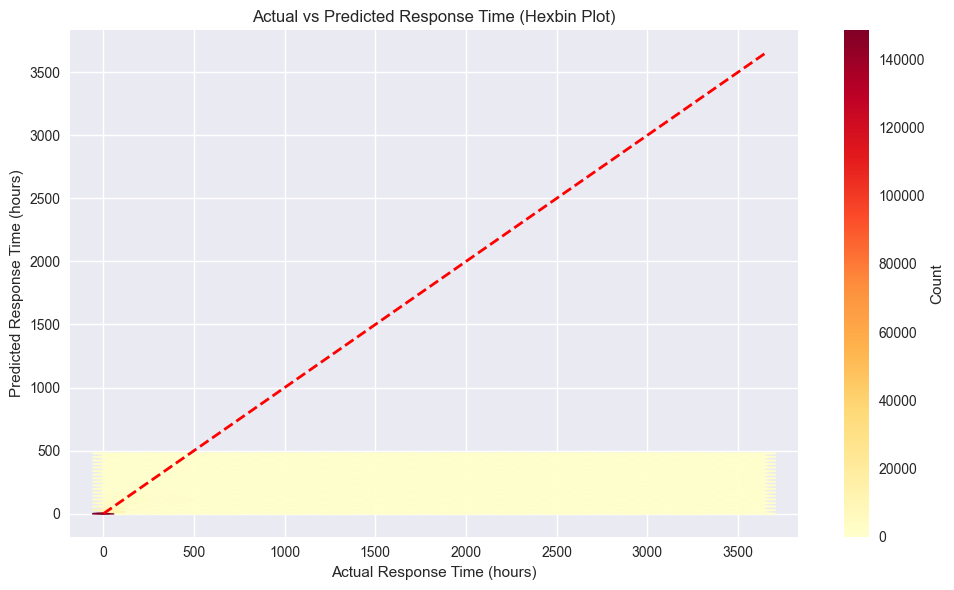

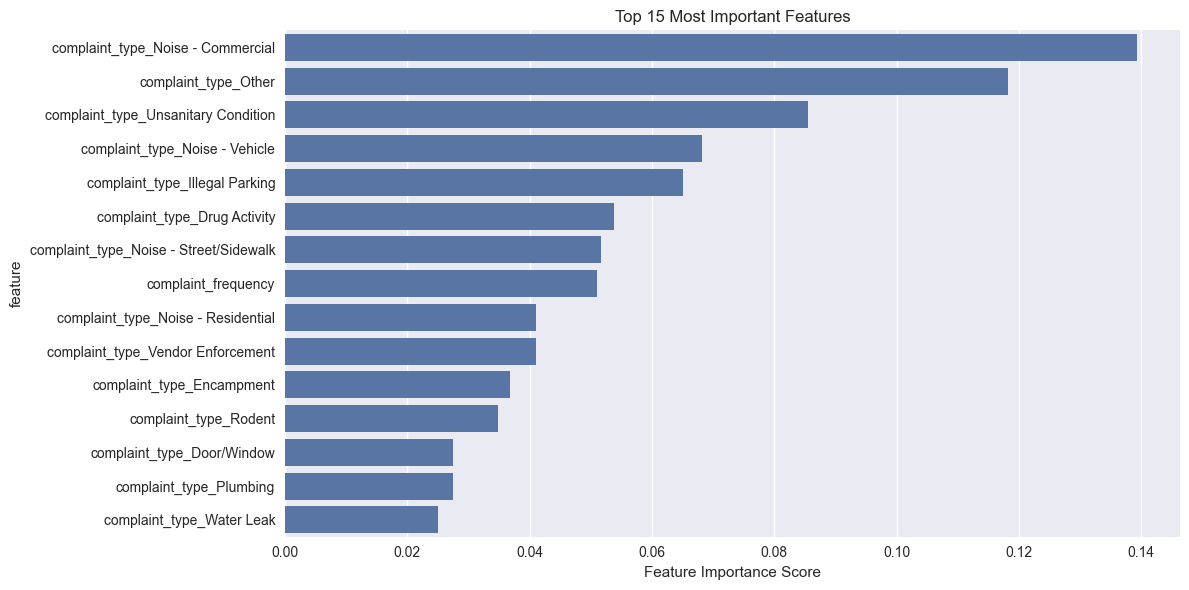

In [85]:
# Train XGBoost with simplified parameters
xgb_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 4,
    'min_child_weight': 2,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'eval_metric': 'rmse'
}

model = xgb.XGBRegressor(**xgb_params)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

# Make predictions and inverse transform
y_pred = model.predict(X_test)
y_pred_original = inverse_func(y_pred)
y_test_original = inverse_func(y_test)

# 1Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print("\nModel Performance Metrics:")
print(f"RMSE: {rmse:.2f} hours")
print(f"MAE: {mae:.2f} hours")
print(f"R2 Score: {r2:.3f}")

# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.hexbin(y_test_original, y_pred_original, gridsize=30, cmap='YlOrRd')
plt.plot([0, y_test_original.max()], [0, y_test_original.max()], 'r--', lw=2)
plt.xlabel('Actual Response Time (hours)')
plt.ylabel('Predicted Response Time (hours)')
plt.title('Actual vs Predicted Response Time (Hexbin Plot)')
plt.colorbar(label='Count')
plt.tight_layout()
plt.show()

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Top 15 Most Important Features')
plt.xlabel('Feature Importance Score')
plt.tight_layout()
plt.show()

# Error Analysis by Borough
df_results = pd.DataFrame({
    'Actual': y_test_original,
    'Predicted': y_pred_original,
    'Error': np.abs(y_test_original - y_pred_original)
})

In [81]:
df_results

,Actual,Predicted,Error
1207212,383.513333,74.164507,309.348826
1207213,169.216667,55.605402,113.611265
1207214,0.617222,1.365324,0.748102
1207215,4.185000,2.463055,1.721945
1207216,53.343611,22.984716,30.358895
...,...,...,...
1499995,1.805278,1.456719,0.348559
1499996,1.848611,2.952911,1.104300
1499997,6.535278,2.618262,3.917015
1499998,5.618333,1.979079,3.639255


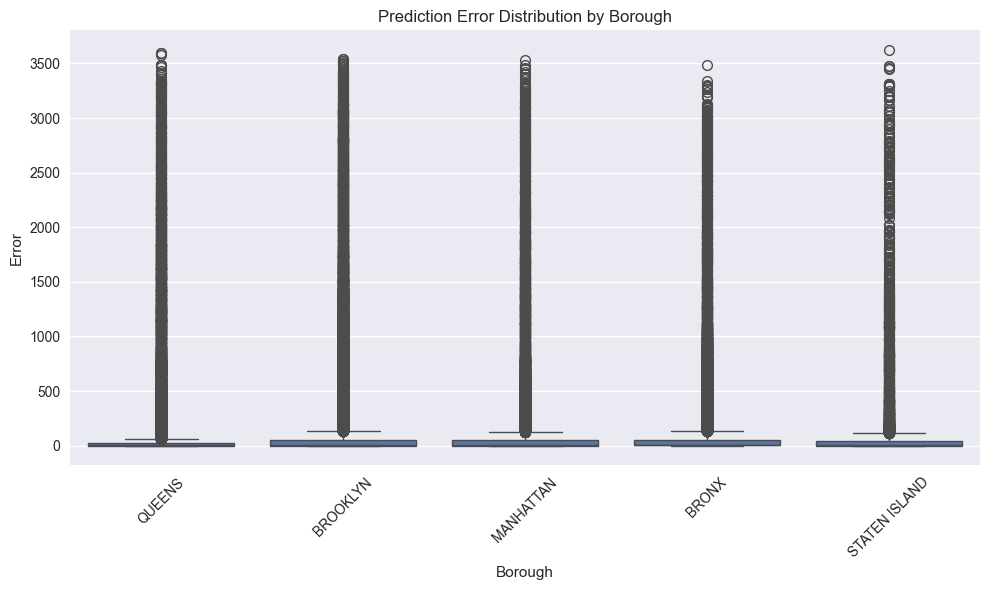

In [84]:
# Add borough information back
df_results['Borough'] = df_model.iloc[split_idx:]['borough'].values

plt.figure(figsize=(10, 6))
sns.boxplot(x='Borough', y='Error', data=df_results)
plt.xticks(rotation=45)
plt.title('Prediction Error Distribution by Borough')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'objective': ['reg:squarederror'],
    'eval_metric': ['rmse']
}

# Initialize the model
xgb_model = xgb.XGBRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use negative RMSE for evaluation
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all available CPUs
    verbose=2
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score (RMSE):", np.sqrt(-grid_search.best_score_))

# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate metrics
y_pred_original = inverse_func(y_pred)
y_test_original = inverse_func(y_test)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print("\nModel Performance Metrics:")
print(f"RMSE: {rmse:.2f} hours")
print(f"MAE: {mae:.2f} hours")
print(f"R2 Score: {r2:.3f}")

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits
